In [1]:
import toml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

In [2]:
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/param_scan_02/stage_02')

In [3]:
subfolders = [f for f in folder.glob('*/') if f.is_dir()]

In [4]:
def get_mag(s):
    if s == 'K':
        return 1e3
    elif s == 'M':
        return 1e6
    else:
        raise NotImplemented()

In [5]:
# relevant parameters are: lightning/arch, model/init_channel, model/init_depth, model/channel_scaling, model/depth_scaling
results = []
for f in tqdm(subfolders):
    try:
        config = toml.load(f / "config.toml")
        mse_df = pd.read_csv(f / "size_norm_scan" / "version_0" / "metrics.csv")
        train_mse = mse_df['train_loss'].min()
        mse = mse_df['val_loss'].min()
        max_epoch = mse_df['epoch'].max()
        validation = pd.read_parquet(f / "test" / "behavior_validation_results.parquet").mean(numeric_only=True)
        with open(list(f.glob('model*.out'))[0], 'r') as out_f:
            for line in out_f.readlines():
                if "Total params" in line:
                    params = line.split(' ')[:2]
                    params = float(params[0]) * get_mag(params[1])
        results.append(dict(
            depth=config['model']['depth'],
            arch=config['model']['lightning']['arch'],
            channel_scaling=config['model']['channel_scaling'],
            depth_scaling=config['model']['depth_scaling'],
            init_depth=config['model']['init_depth'],
            init_channel=config['model']['init_channel'],
            mse=mse,
            train_mse=train_mse,
            epoch=max_epoch,
            heldout_beh_val=validation['heldout_score'],
            fit_beh_val=validation['fit_score'],
            param_count=params,
            file=str(f / "model.pt"),
        ))
    except Exception:
        continue
results = pd.DataFrame(results).query('epoch == 84')

  0%|          | 0/672 [00:00<?, ?it/s]

In [24]:
results.to_parquet('/n/groups/datta/win/longtogeny/data/size_network/analysis/param_scan_results.parquet')

In [25]:
results

depth       arch  channel_scaling  depth_scaling  init_depth  \
0        4         ae         1.000000       1.000000           1   
1        4       unet         1.000000       1.333333           2   
3        4         ae         2.333333       1.333333           2   
4        4       unet         3.000000       1.333333           2   
5        4       unet         2.666667       1.000000           1   
..     ...        ...              ...            ...         ...   
204      4       unet         1.000000       1.333333           1   
205      4  efficient         3.000000       1.000000           1   
206      4         ae         2.333333       1.000000           1   
207      4         ae         2.333333       1.333333           2   
208      4         ae         2.666667       1.000000           1   

     init_channel       mse  train_mse  epoch  heldout_beh_val  fit_beh_val  \
0              16  0.001451   0.001149     84         0.018538     0.415241   
1              32  0.001224   0.000954     84         0.078177     0.466895   
3              16  0.001159   0.000868     84         0.042399     0.437866   
4               8  0.001159   0.000945     84         0.046535     0.460374   
5               8  0.001300   0.000952     84         0.085228     0.494479   
..            ...       ...        ...    ...              ...          ...   
204            32  0.001284   0.001000     84         0.111165     0.503668   
205             8  0.001093   0.000835     84         0.050572     0.450402   
206            64  0.001041   0.000773     84         0.133628     0.498179   
207            32  0.001092   0.000849     84        -0.043828     0.426258   
208            32  0.001097   0.000847     84         0.111611     0.493262   

     param_count                                               file  
0         8000.0  /n/groups/datta/win/longtogeny/size_norm/model...  
1        64200.0  /n/groups/datta/win/longtogeny/size_norm/model...  
3       480000.0  /n/groups/datta/win/longtogeny/size_norm/model...  
4       477000.0  /n/groups/datta/win/longtogeny/size_norm/model...  
5        64400.0  /n/groups/datta/win/longtogeny/size_norm/model...  
..           ...                                                ...  
204      31600.0  /n/groups/datta/win/longtogeny/size_norm/model...  
205     901000.0  /n/groups/datta/win/longtogeny/size_norm/model...  
206    1700000.0  /n/groups/datta/win/longtogeny/size_norm/model...  
207    1800000.0  /n/groups/datta/win/longtogeny/size_norm/model...  
208     841000.0  /n/groups/datta/win/longtogeny/size_norm/model...  

[194 rows x 13 columns]

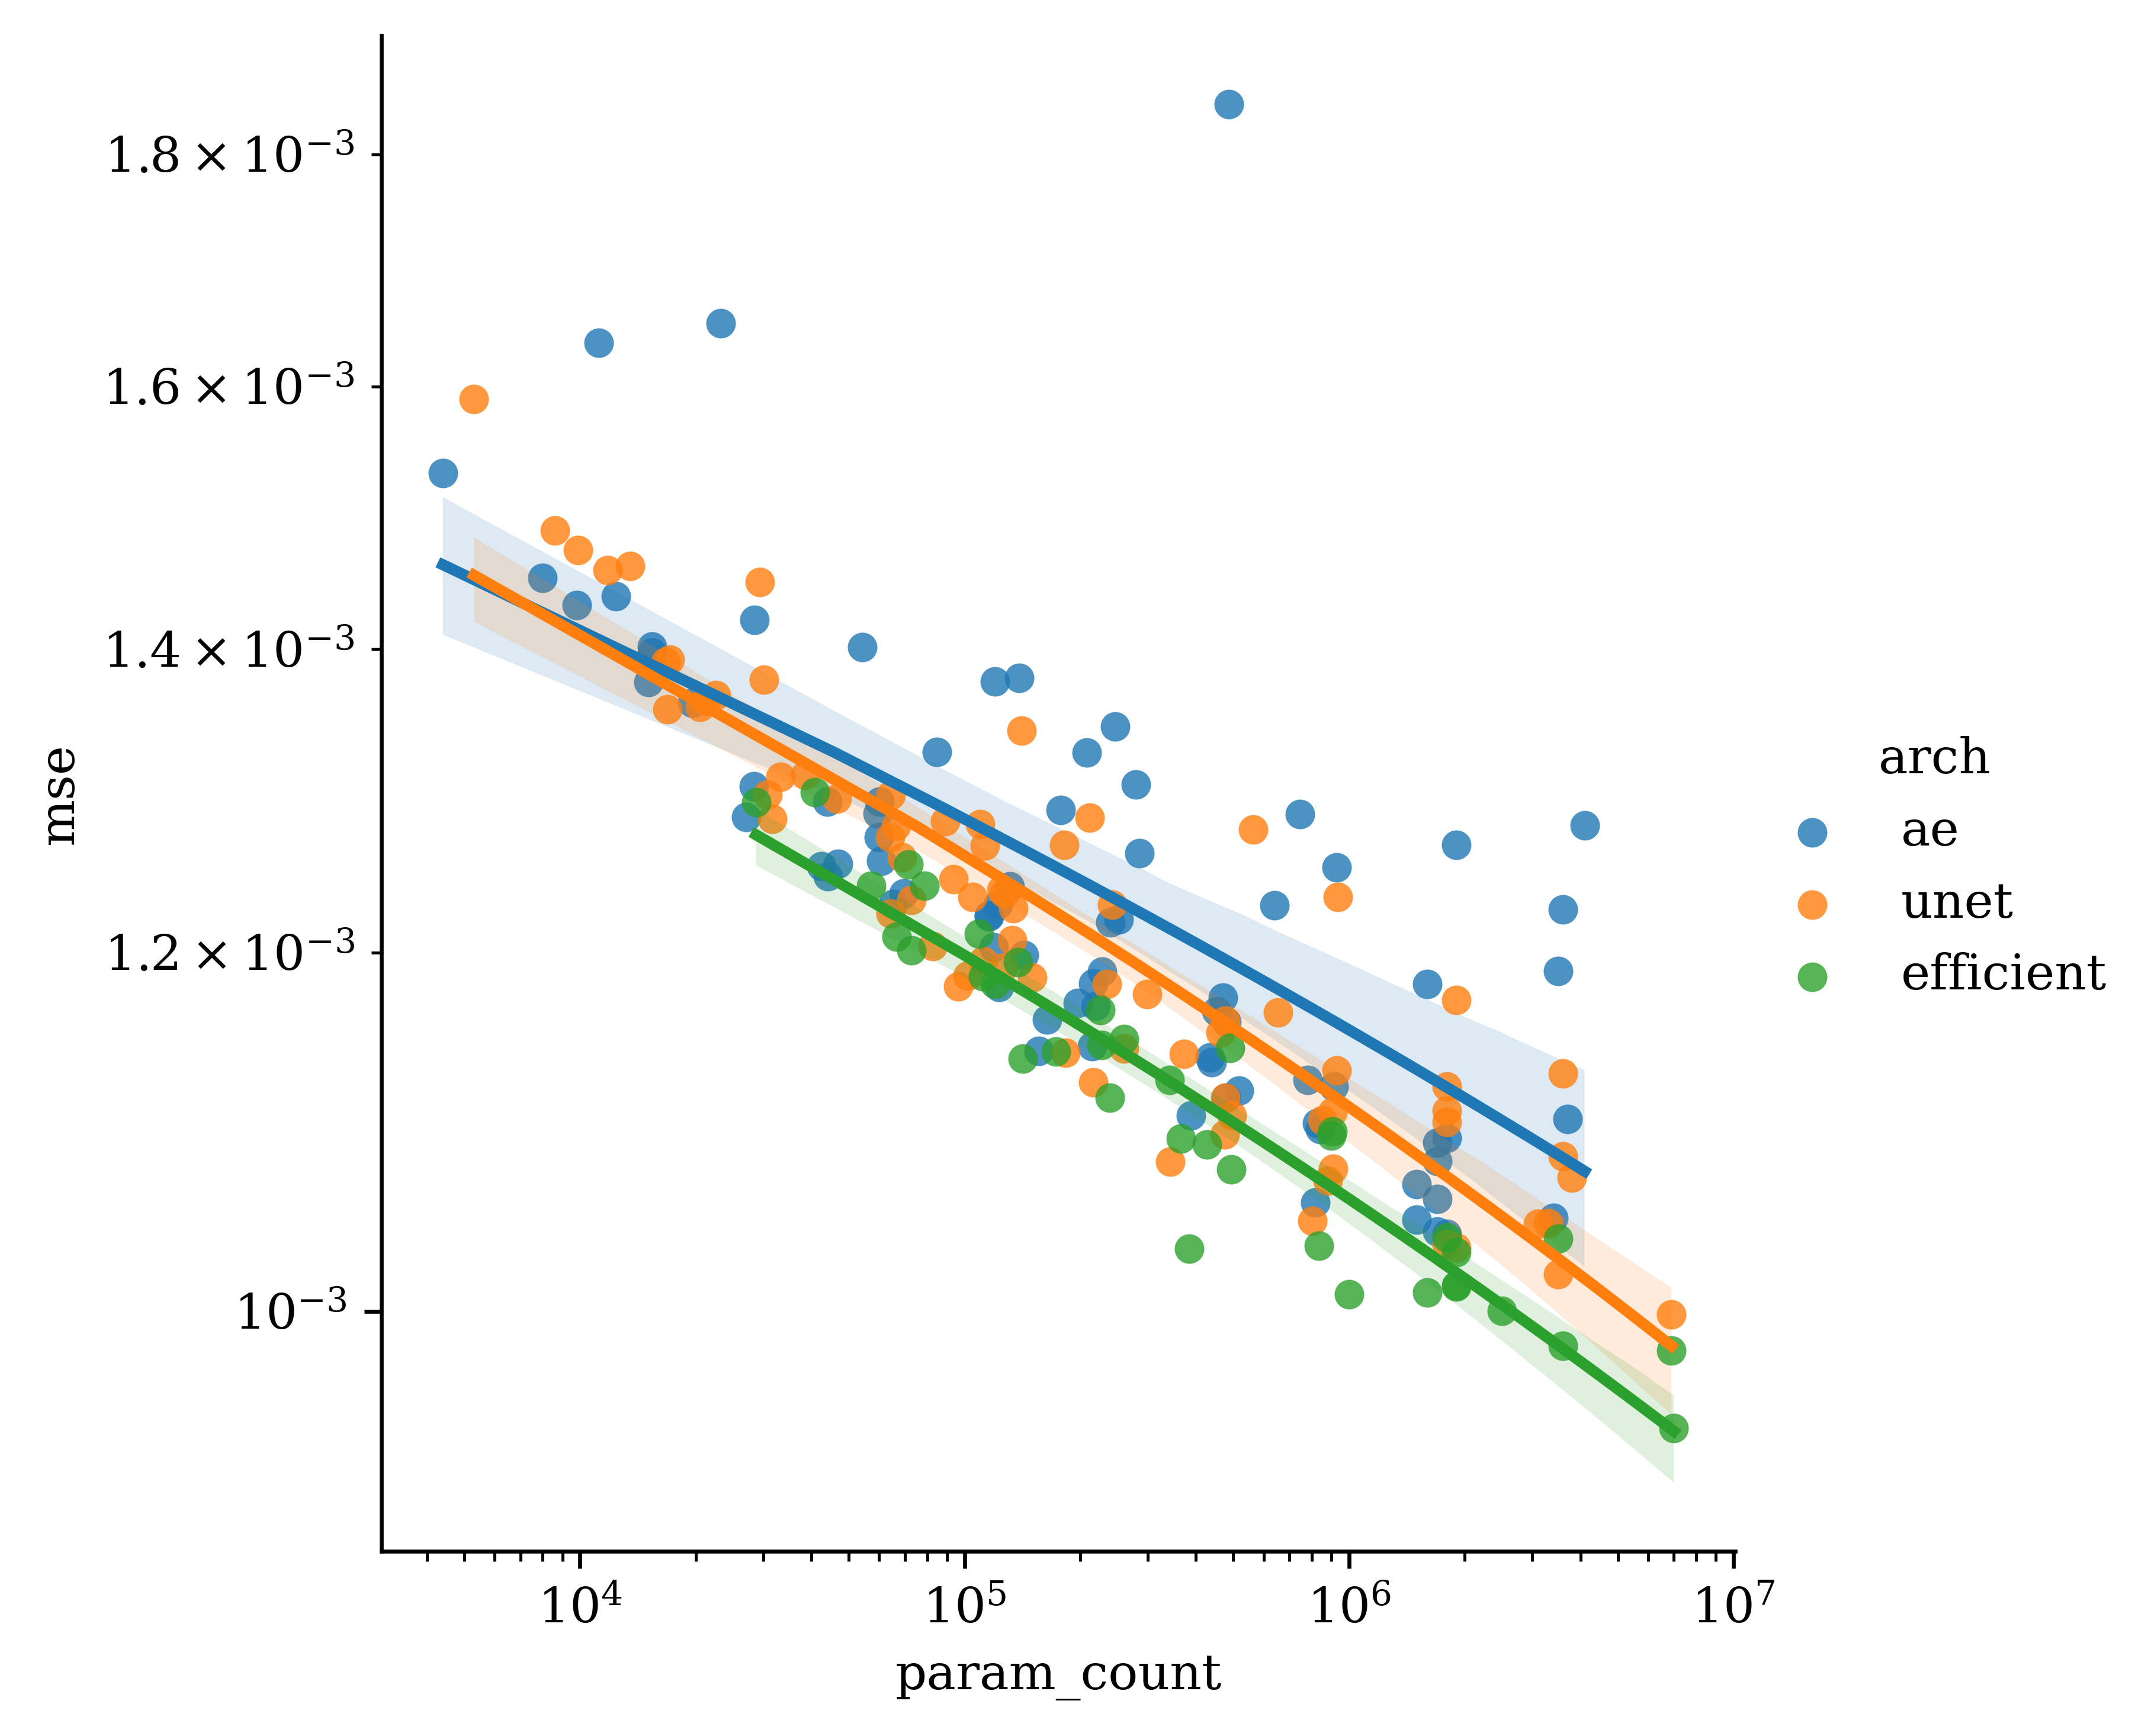

In [26]:
ax = sns.lmplot(data=results, x='param_count', y='mse', hue='arch', logx=True, scatter_kws=dict(lw=0))
ax.set(xscale='log', yscale='log')

## Validation analysis

In [9]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depth            209 non-null    int64  
 1   arch             209 non-null    object 
 2   channel_scaling  209 non-null    float64
 3   depth_scaling    209 non-null    float64
 4   init_depth       209 non-null    int64  
 5   init_channel     209 non-null    int64  
 6   mse              208 non-null    float64
 7   train_mse        209 non-null    float64
 8   epoch            209 non-null    int64  
 9   heldout_beh_val  209 non-null    float64
 10  fit_beh_val      209 non-null    float64
 11  param_count      209 non-null    float64
 12  file             209 non-null    object 
dtypes: float64(7), int64(4), object(2)
memory usage: 21.4+ KB


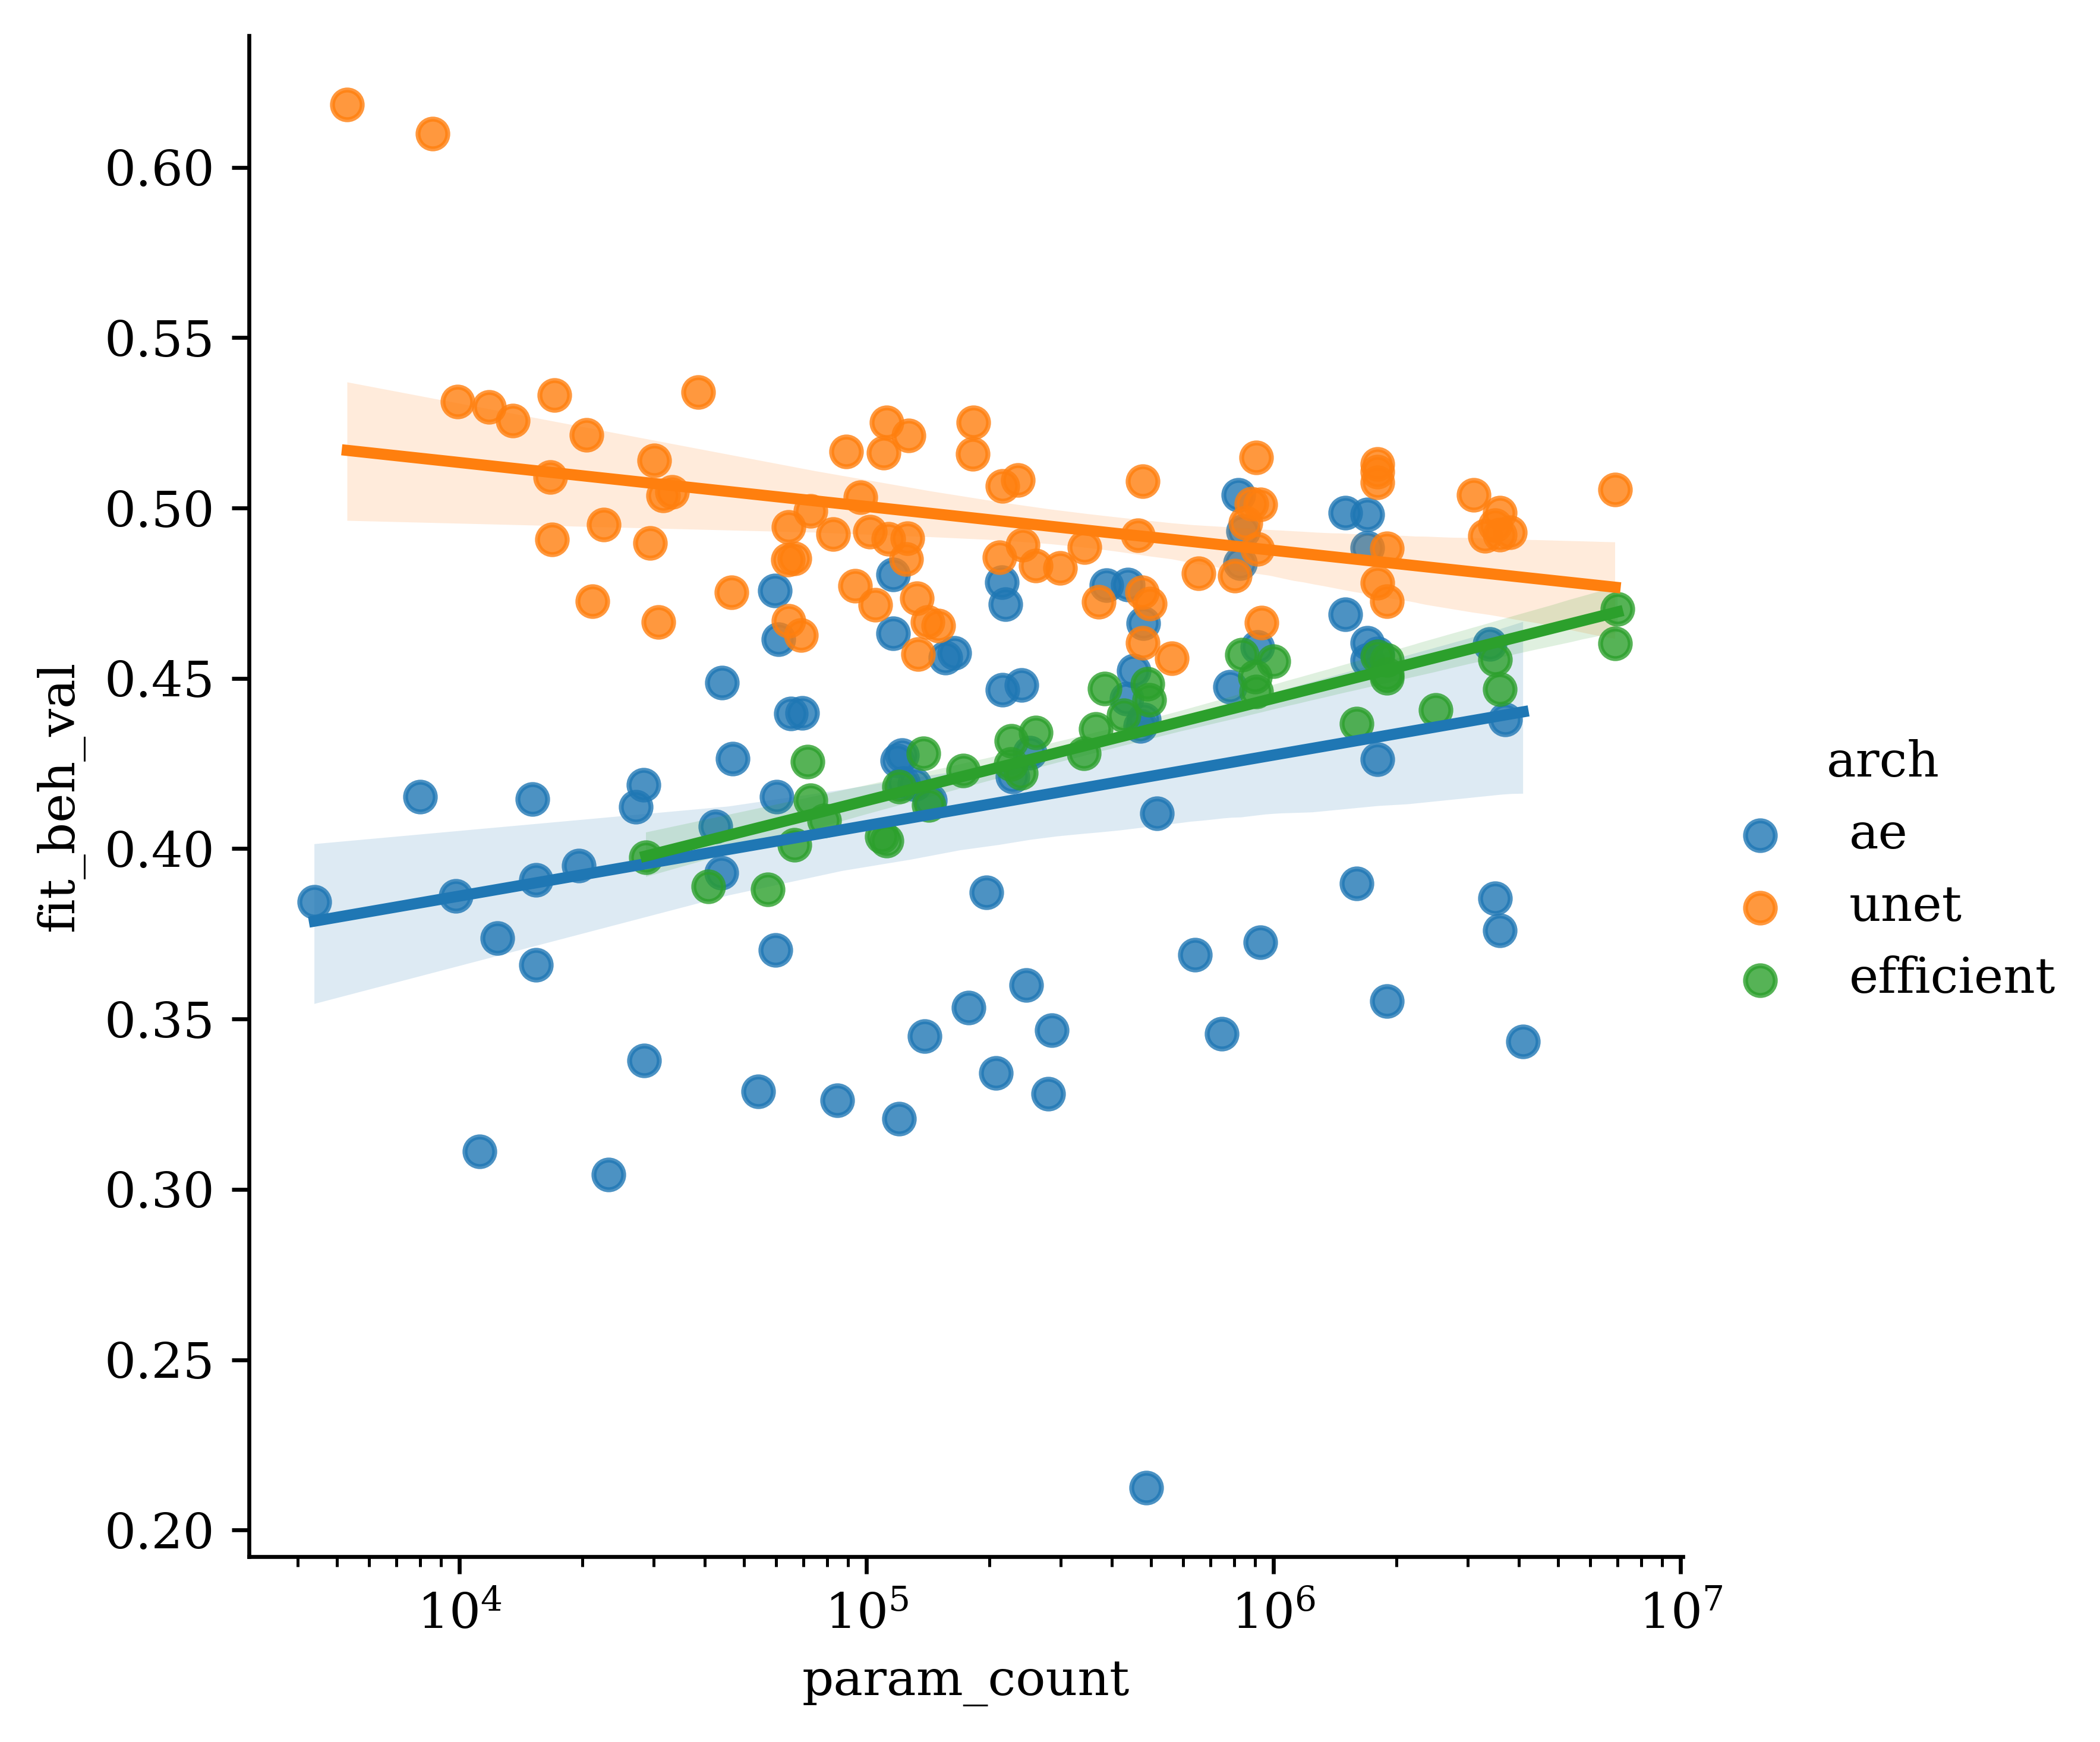

In [27]:
ax = sns.lmplot(data=results, x='param_count', y='fit_beh_val', hue='arch', logx=True)
ax.set(xscale='log')

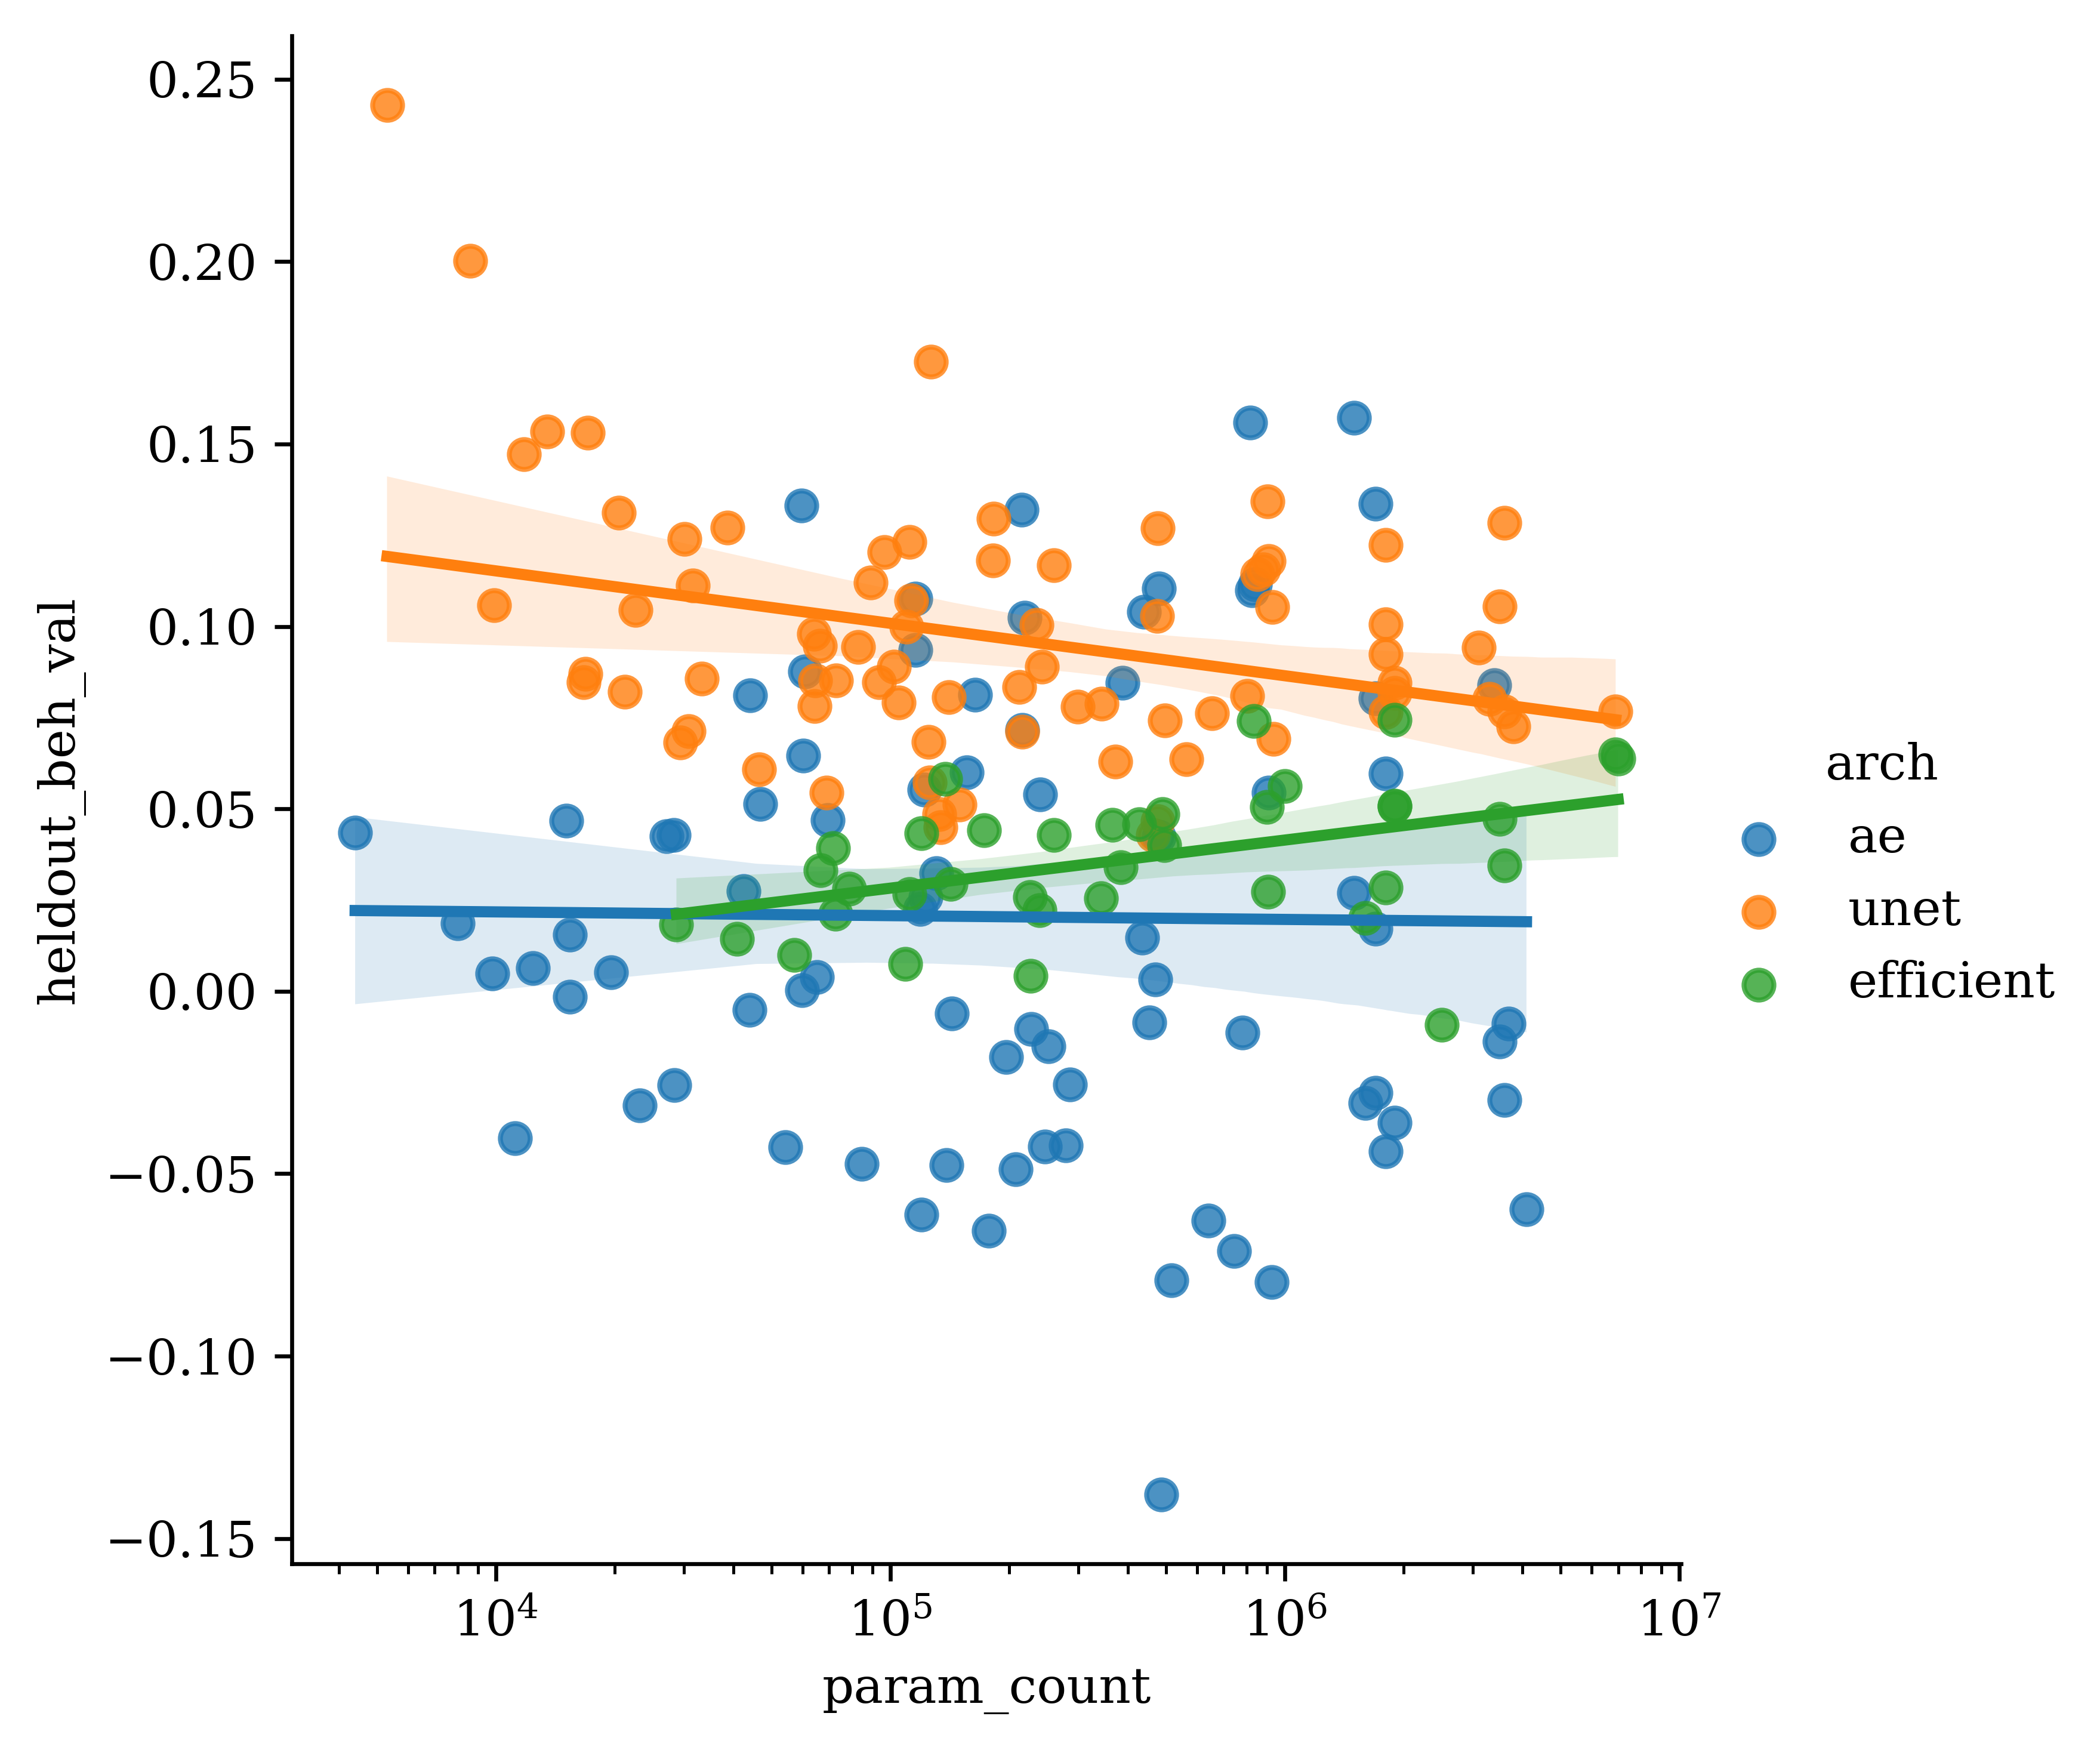

In [28]:
ax = sns.lmplot(data=results, x='param_count', y='heldout_beh_val', hue='arch', logx=True)
ax.set(xscale='log')

In [29]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 208
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depth            194 non-null    int64  
 1   arch             194 non-null    object 
 2   channel_scaling  194 non-null    float64
 3   depth_scaling    194 non-null    float64
 4   init_depth       194 non-null    int64  
 5   init_channel     194 non-null    int64  
 6   mse              194 non-null    float64
 7   train_mse        194 non-null    float64
 8   epoch            194 non-null    int64  
 9   heldout_beh_val  194 non-null    float64
 10  fit_beh_val      194 non-null    float64
 11  param_count      194 non-null    float64
 12  file             194 non-null    object 
dtypes: float64(7), int64(4), object(2)
memory usage: 21.2+ KB


<Axes: xlabel='init_channel', ylabel='mse'>

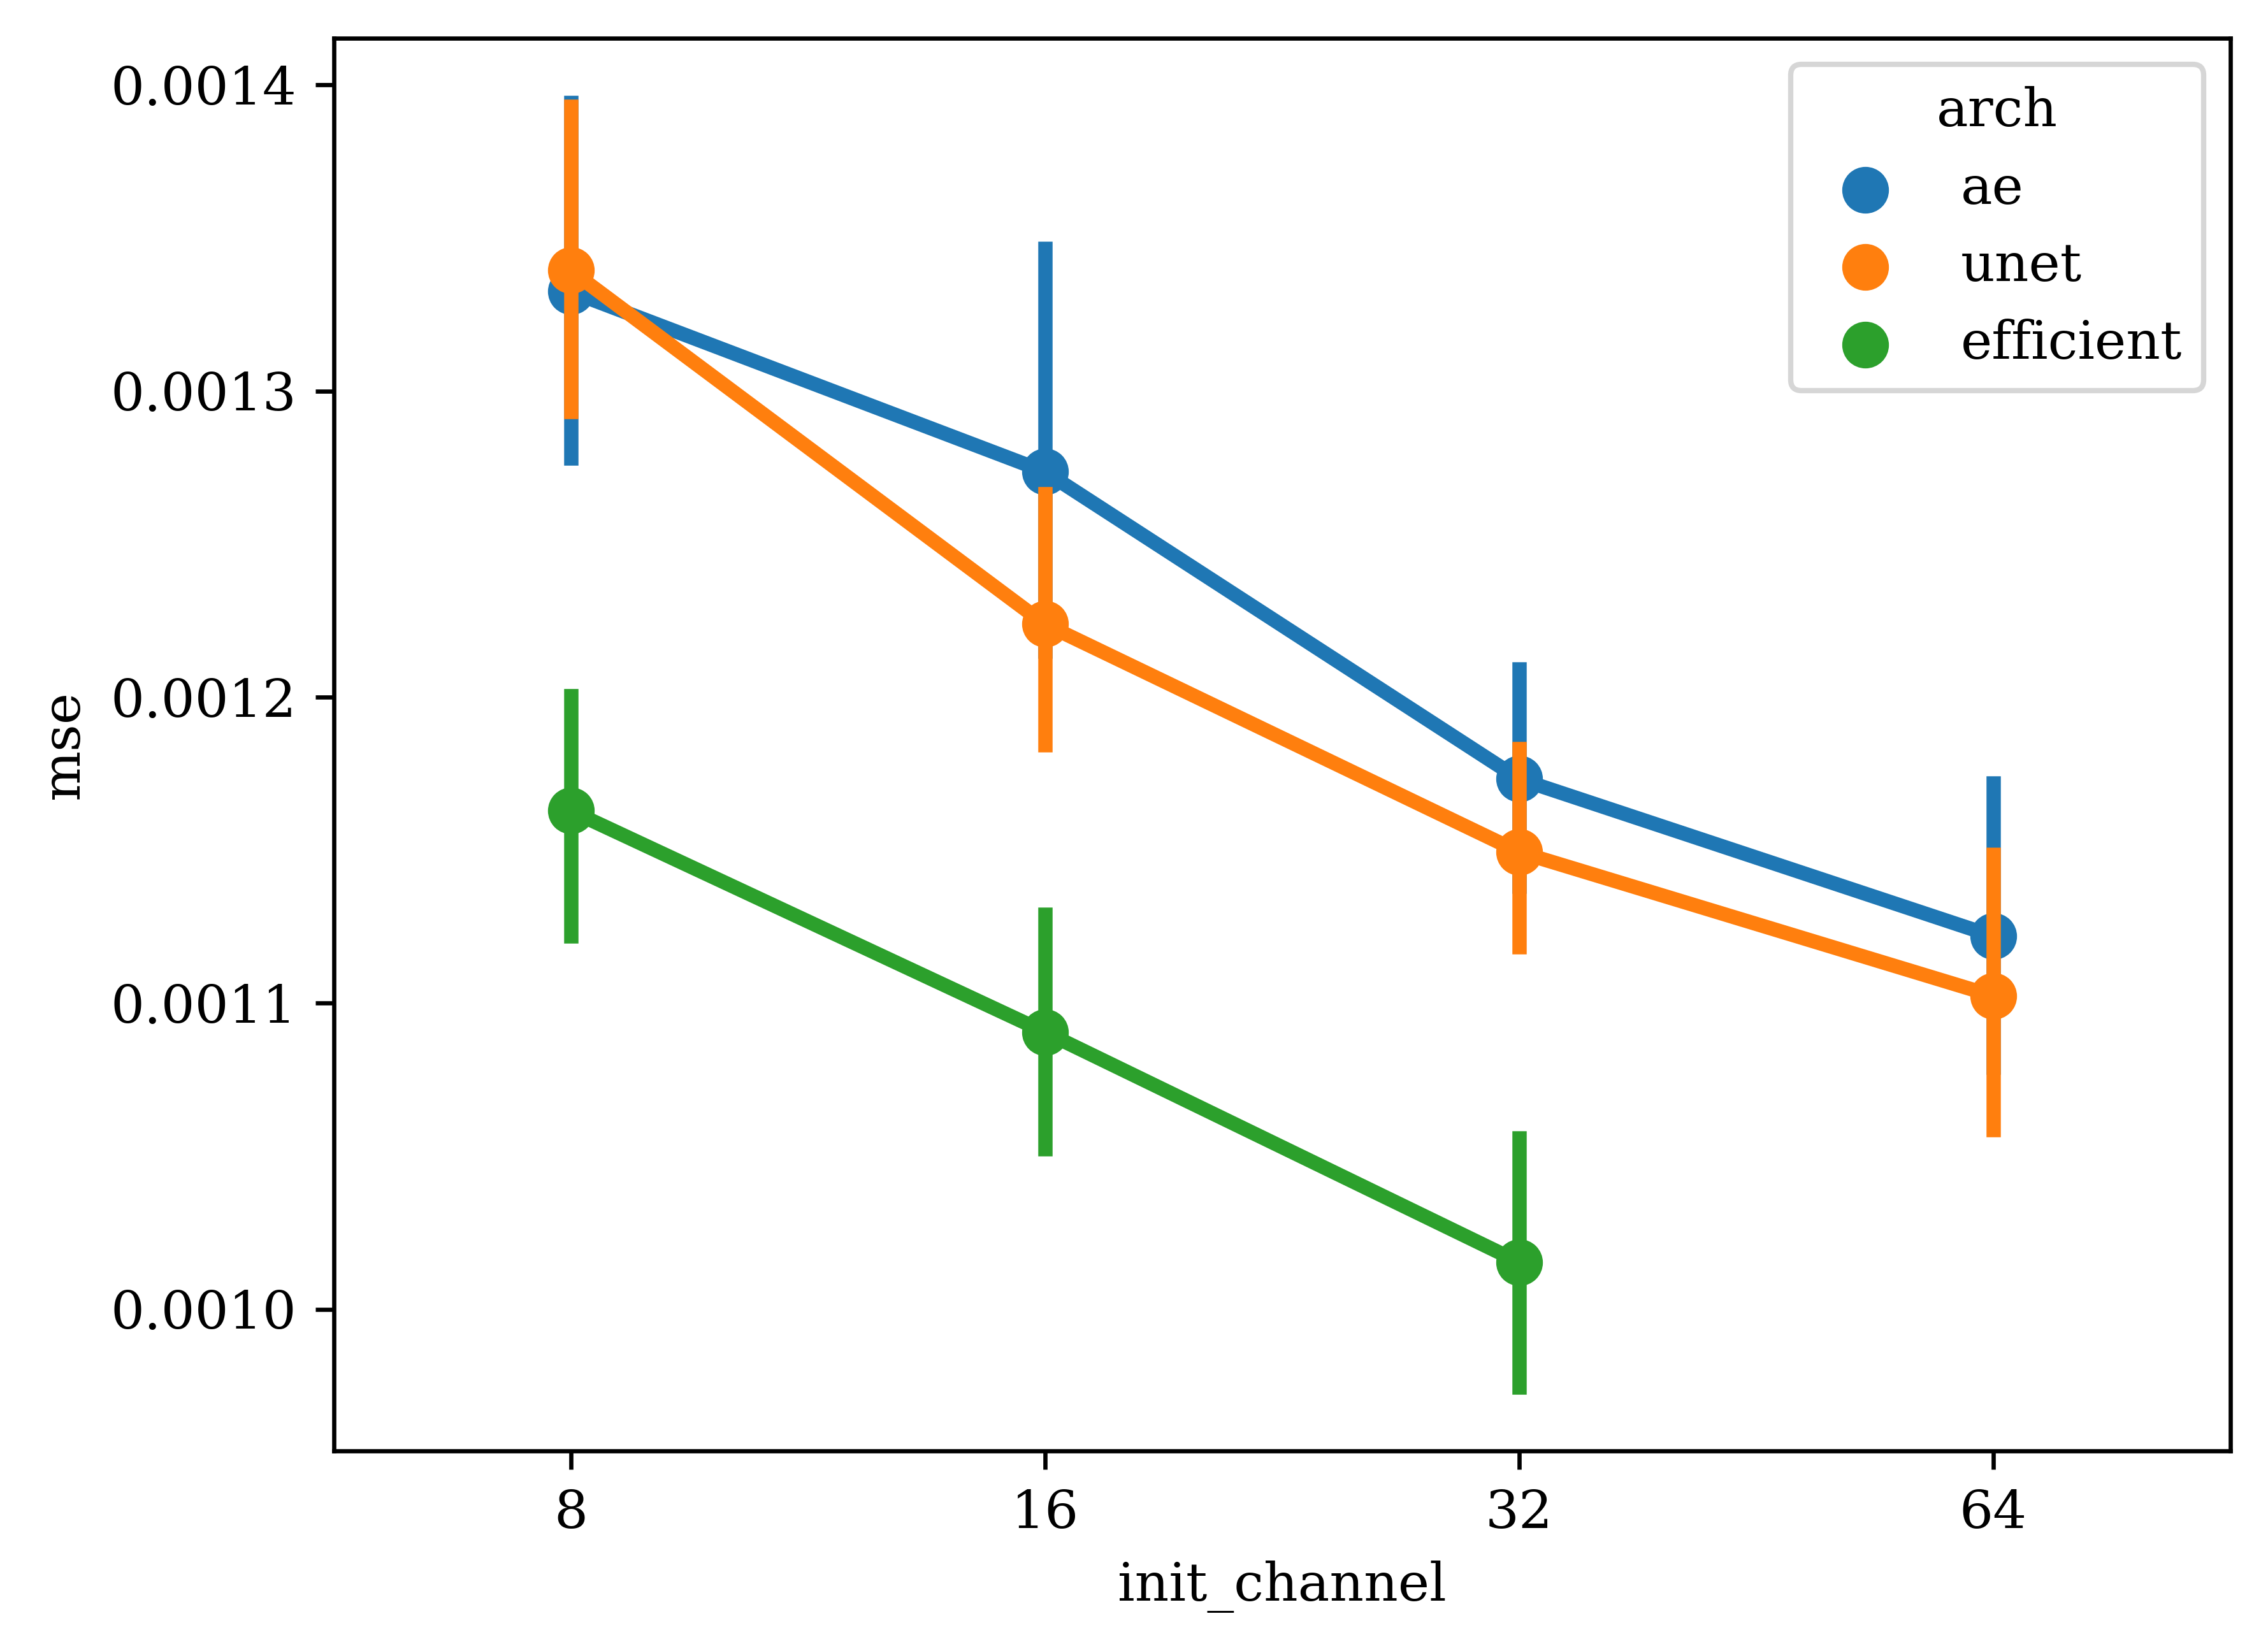

In [30]:
sns.pointplot(data=results, x='init_channel', y='mse', hue='arch')

<Axes: xlabel='init_channel', ylabel='fit_beh_val'>

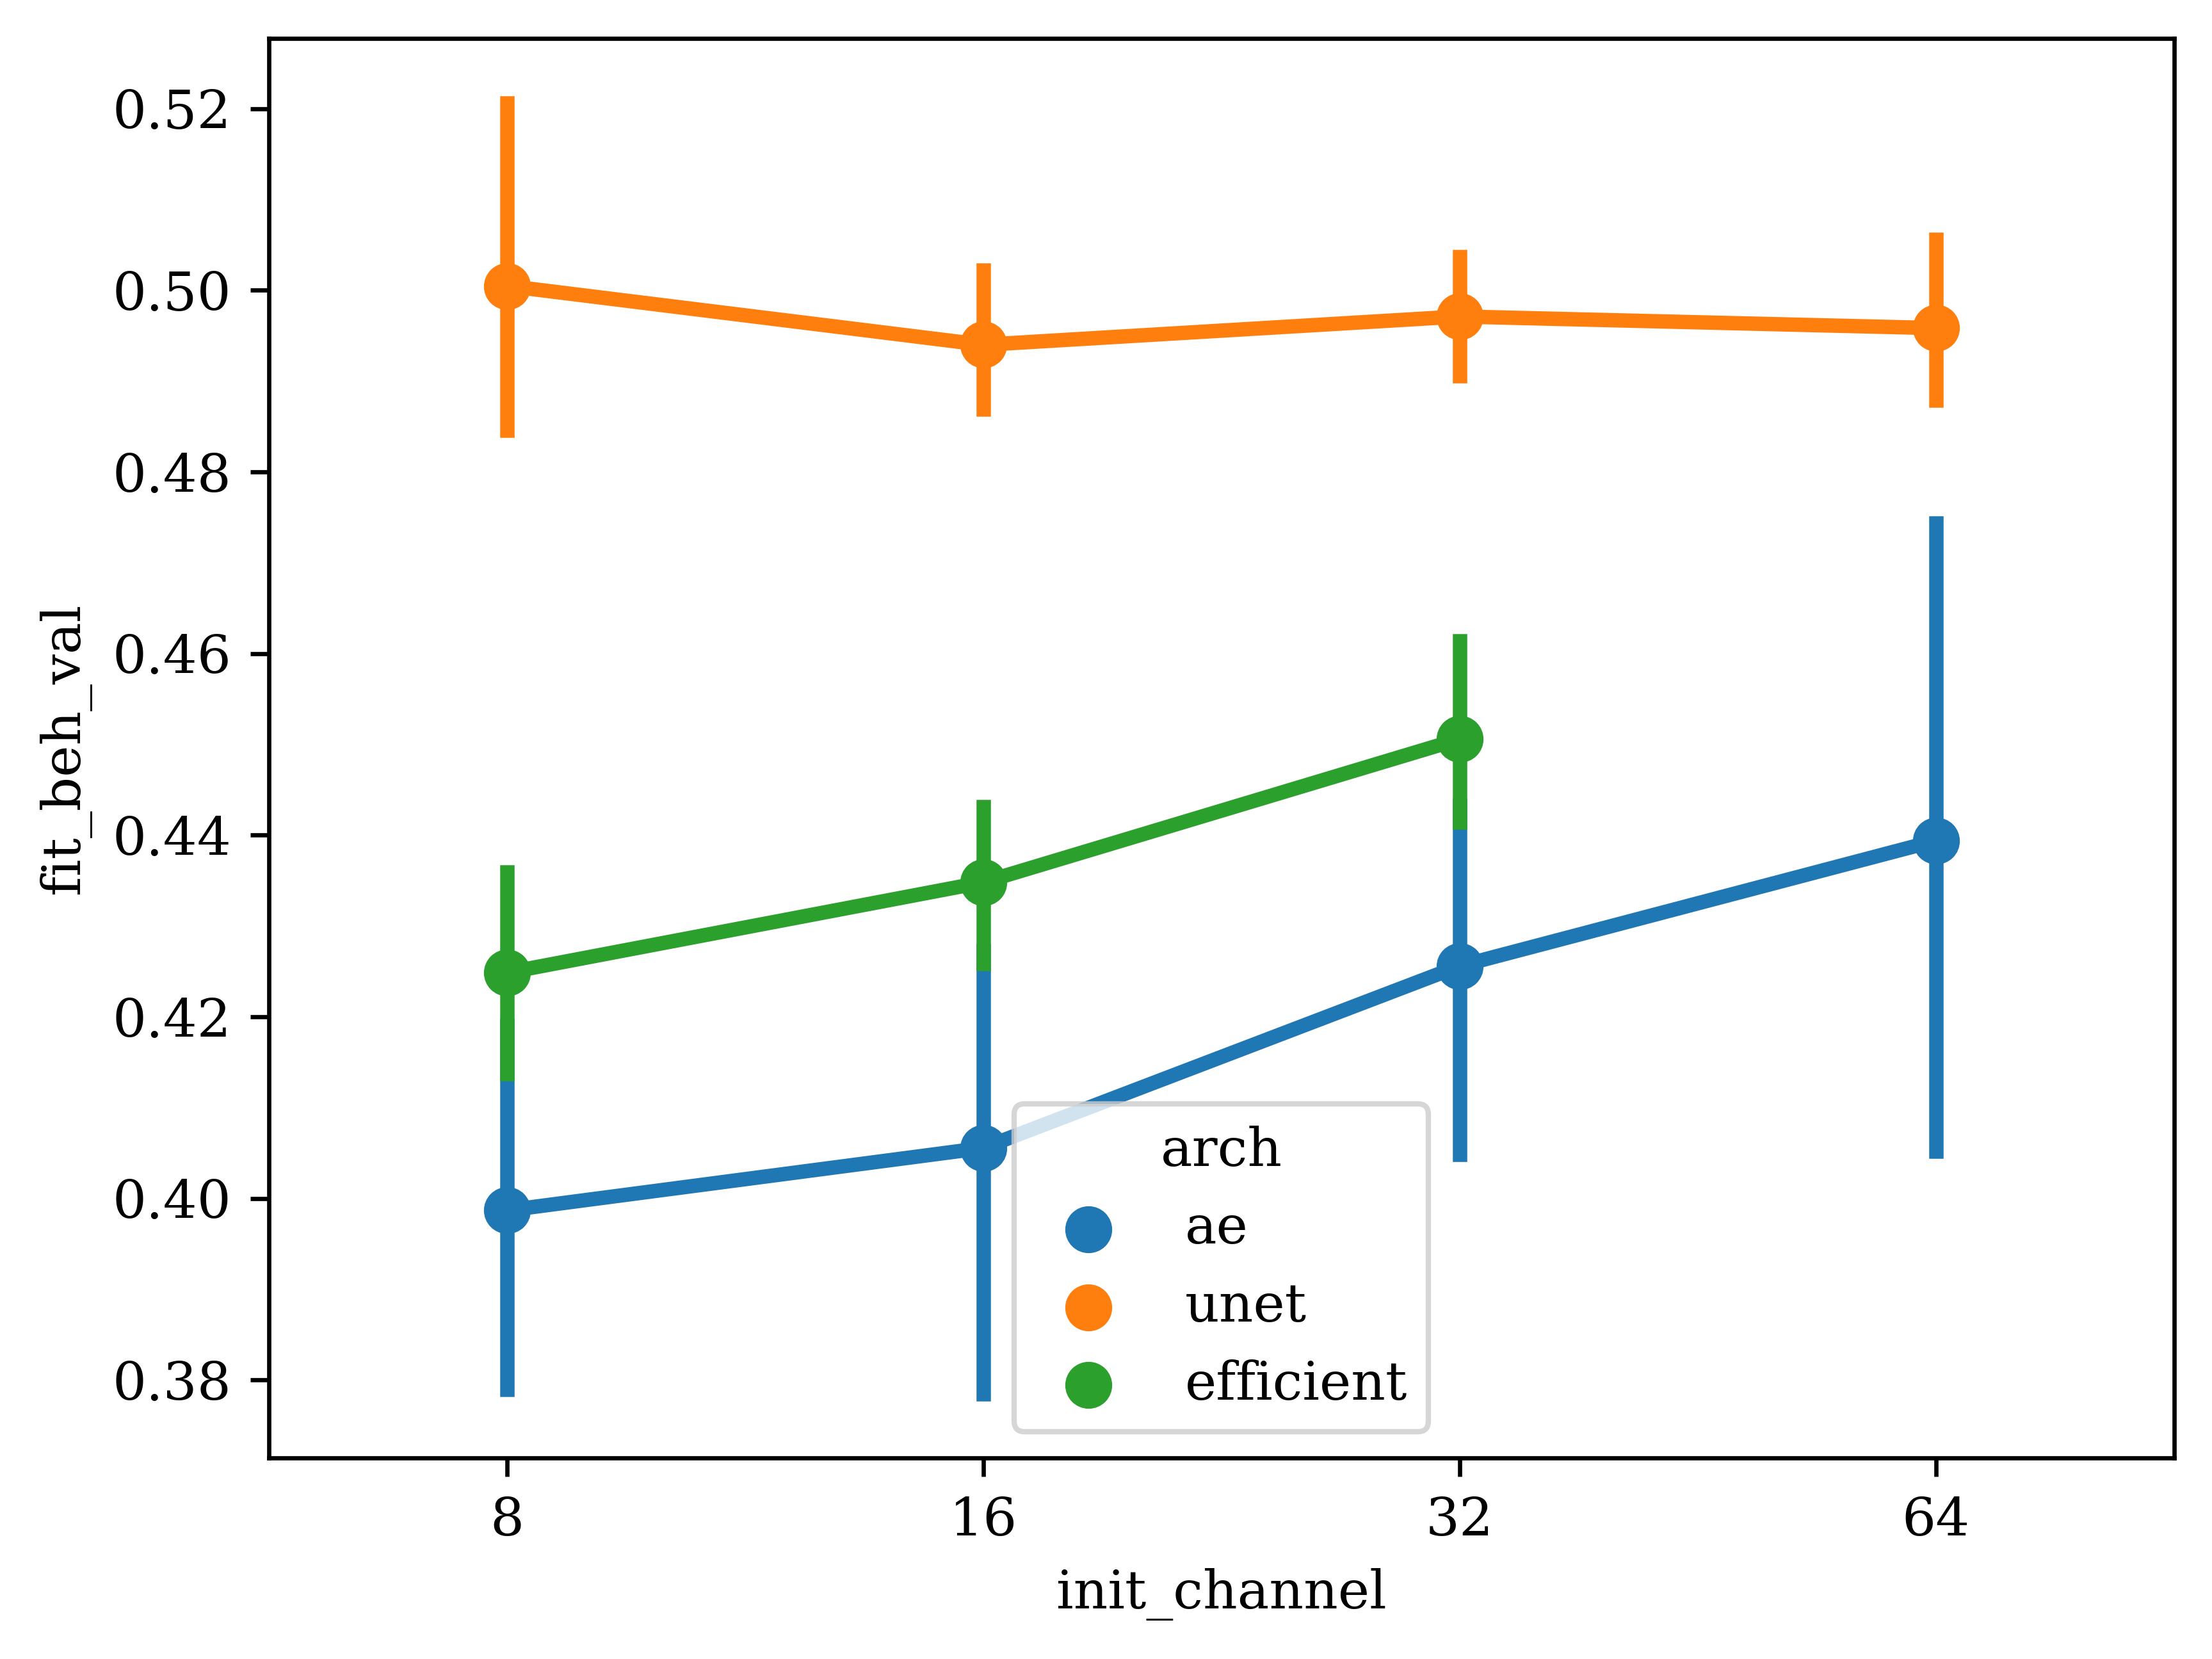

In [31]:
sns.pointplot(data=results, x='init_channel', y='fit_beh_val', hue='arch')

<Axes: xlabel='init_depth', ylabel='mse'>

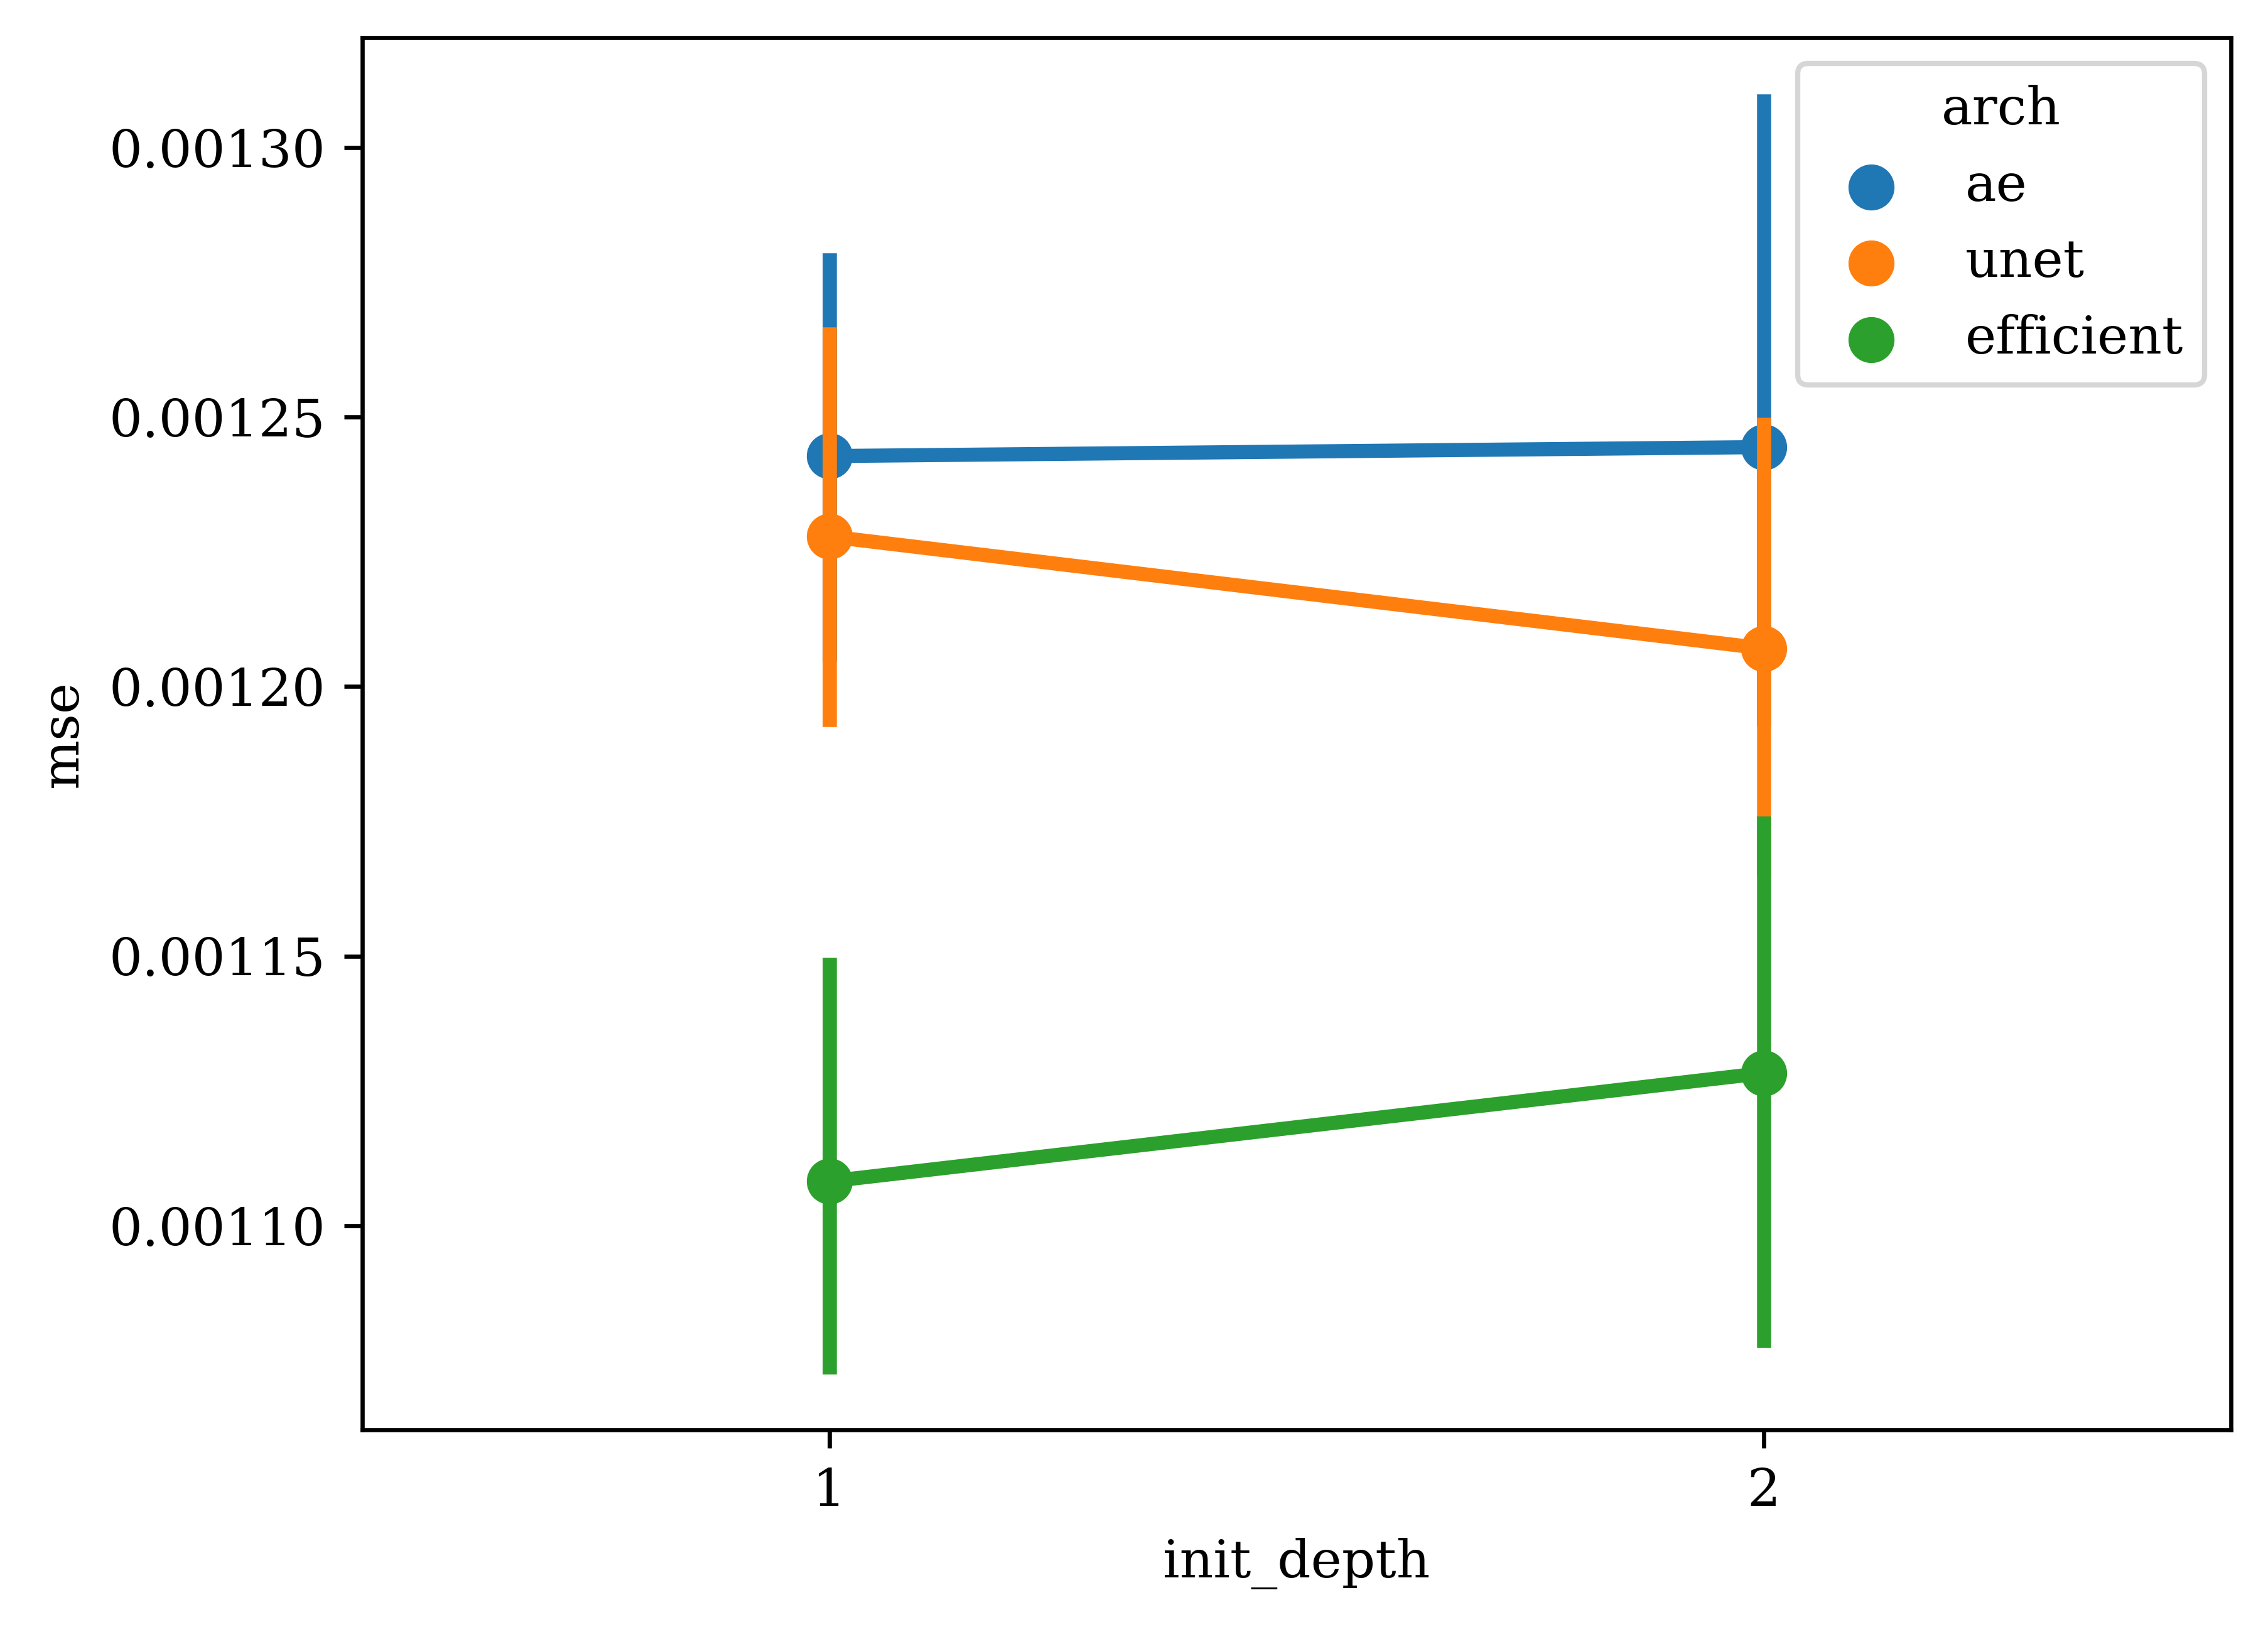

In [32]:
sns.pointplot(data=results, x='init_depth', y='mse', hue='arch')

<Axes: xlabel='init_depth', ylabel='fit_beh_val'>

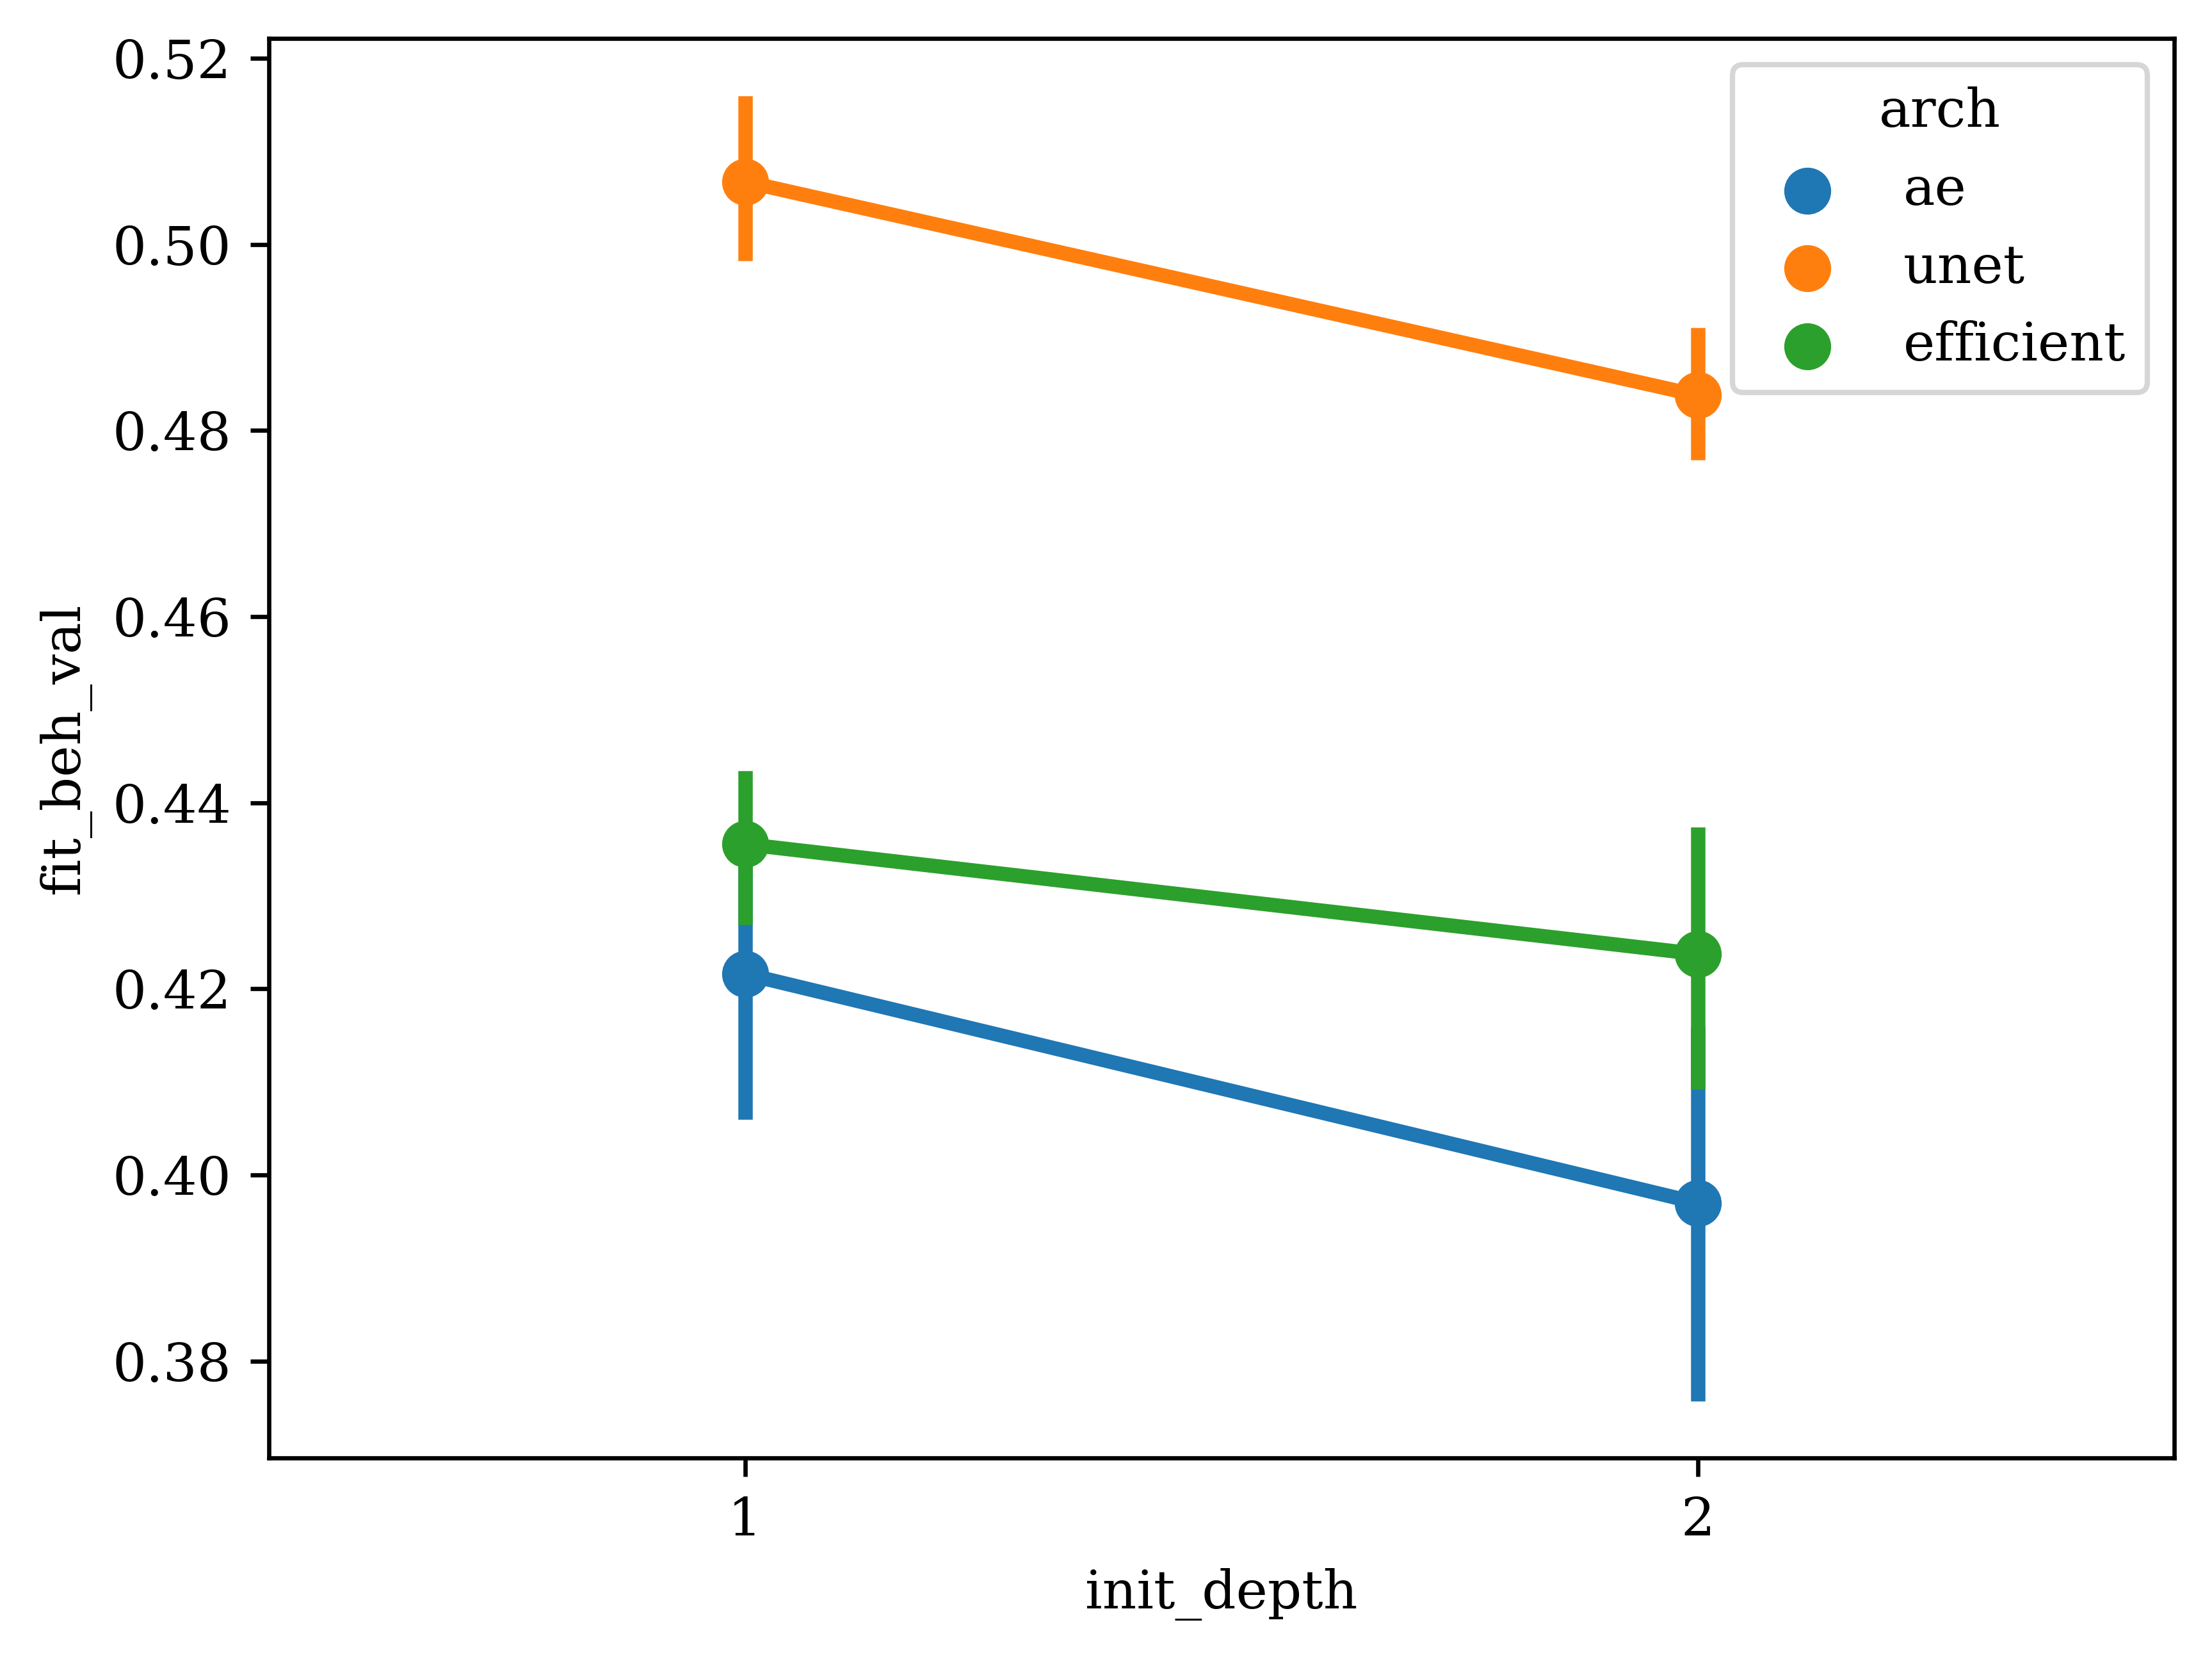

In [33]:
sns.pointplot(data=results, x='init_depth', y='fit_beh_val', hue='arch')

<Axes: xlabel='channel_scaling', ylabel='mse'>

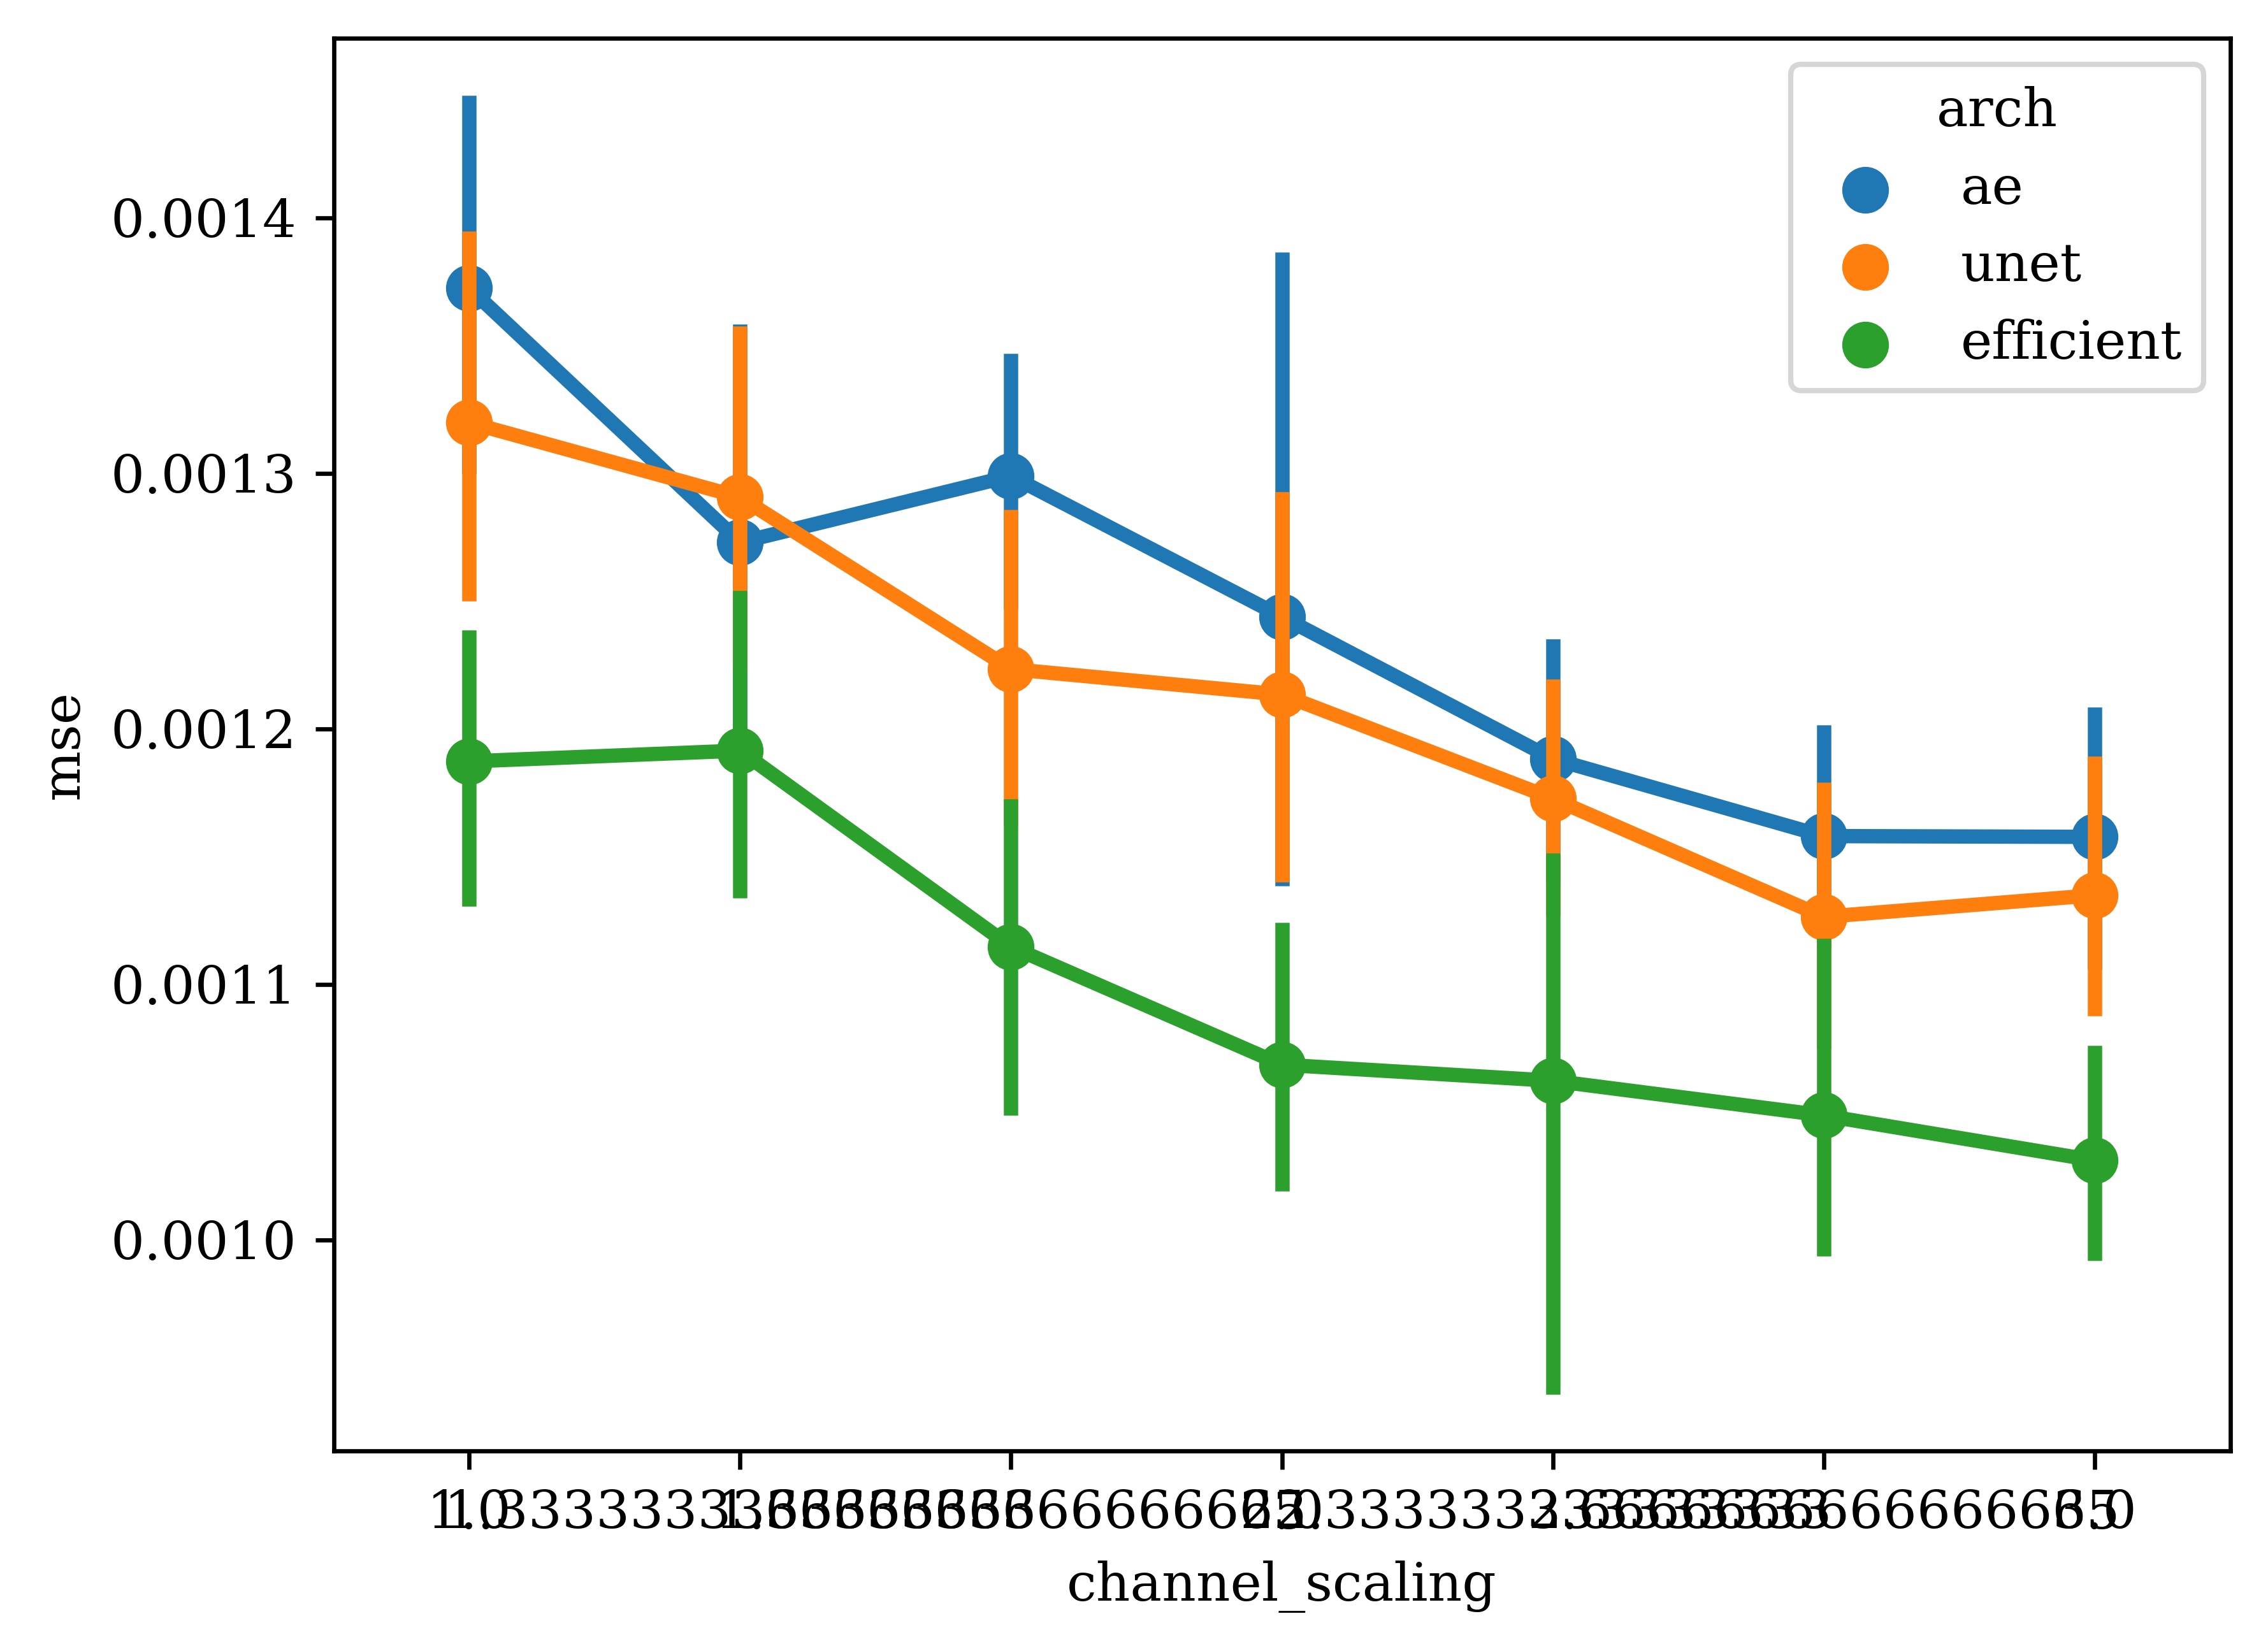

In [34]:
sns.pointplot(data=results, x='channel_scaling', y='mse', hue='arch')

<Axes: xlabel='channel_scaling', ylabel='fit_beh_val'>

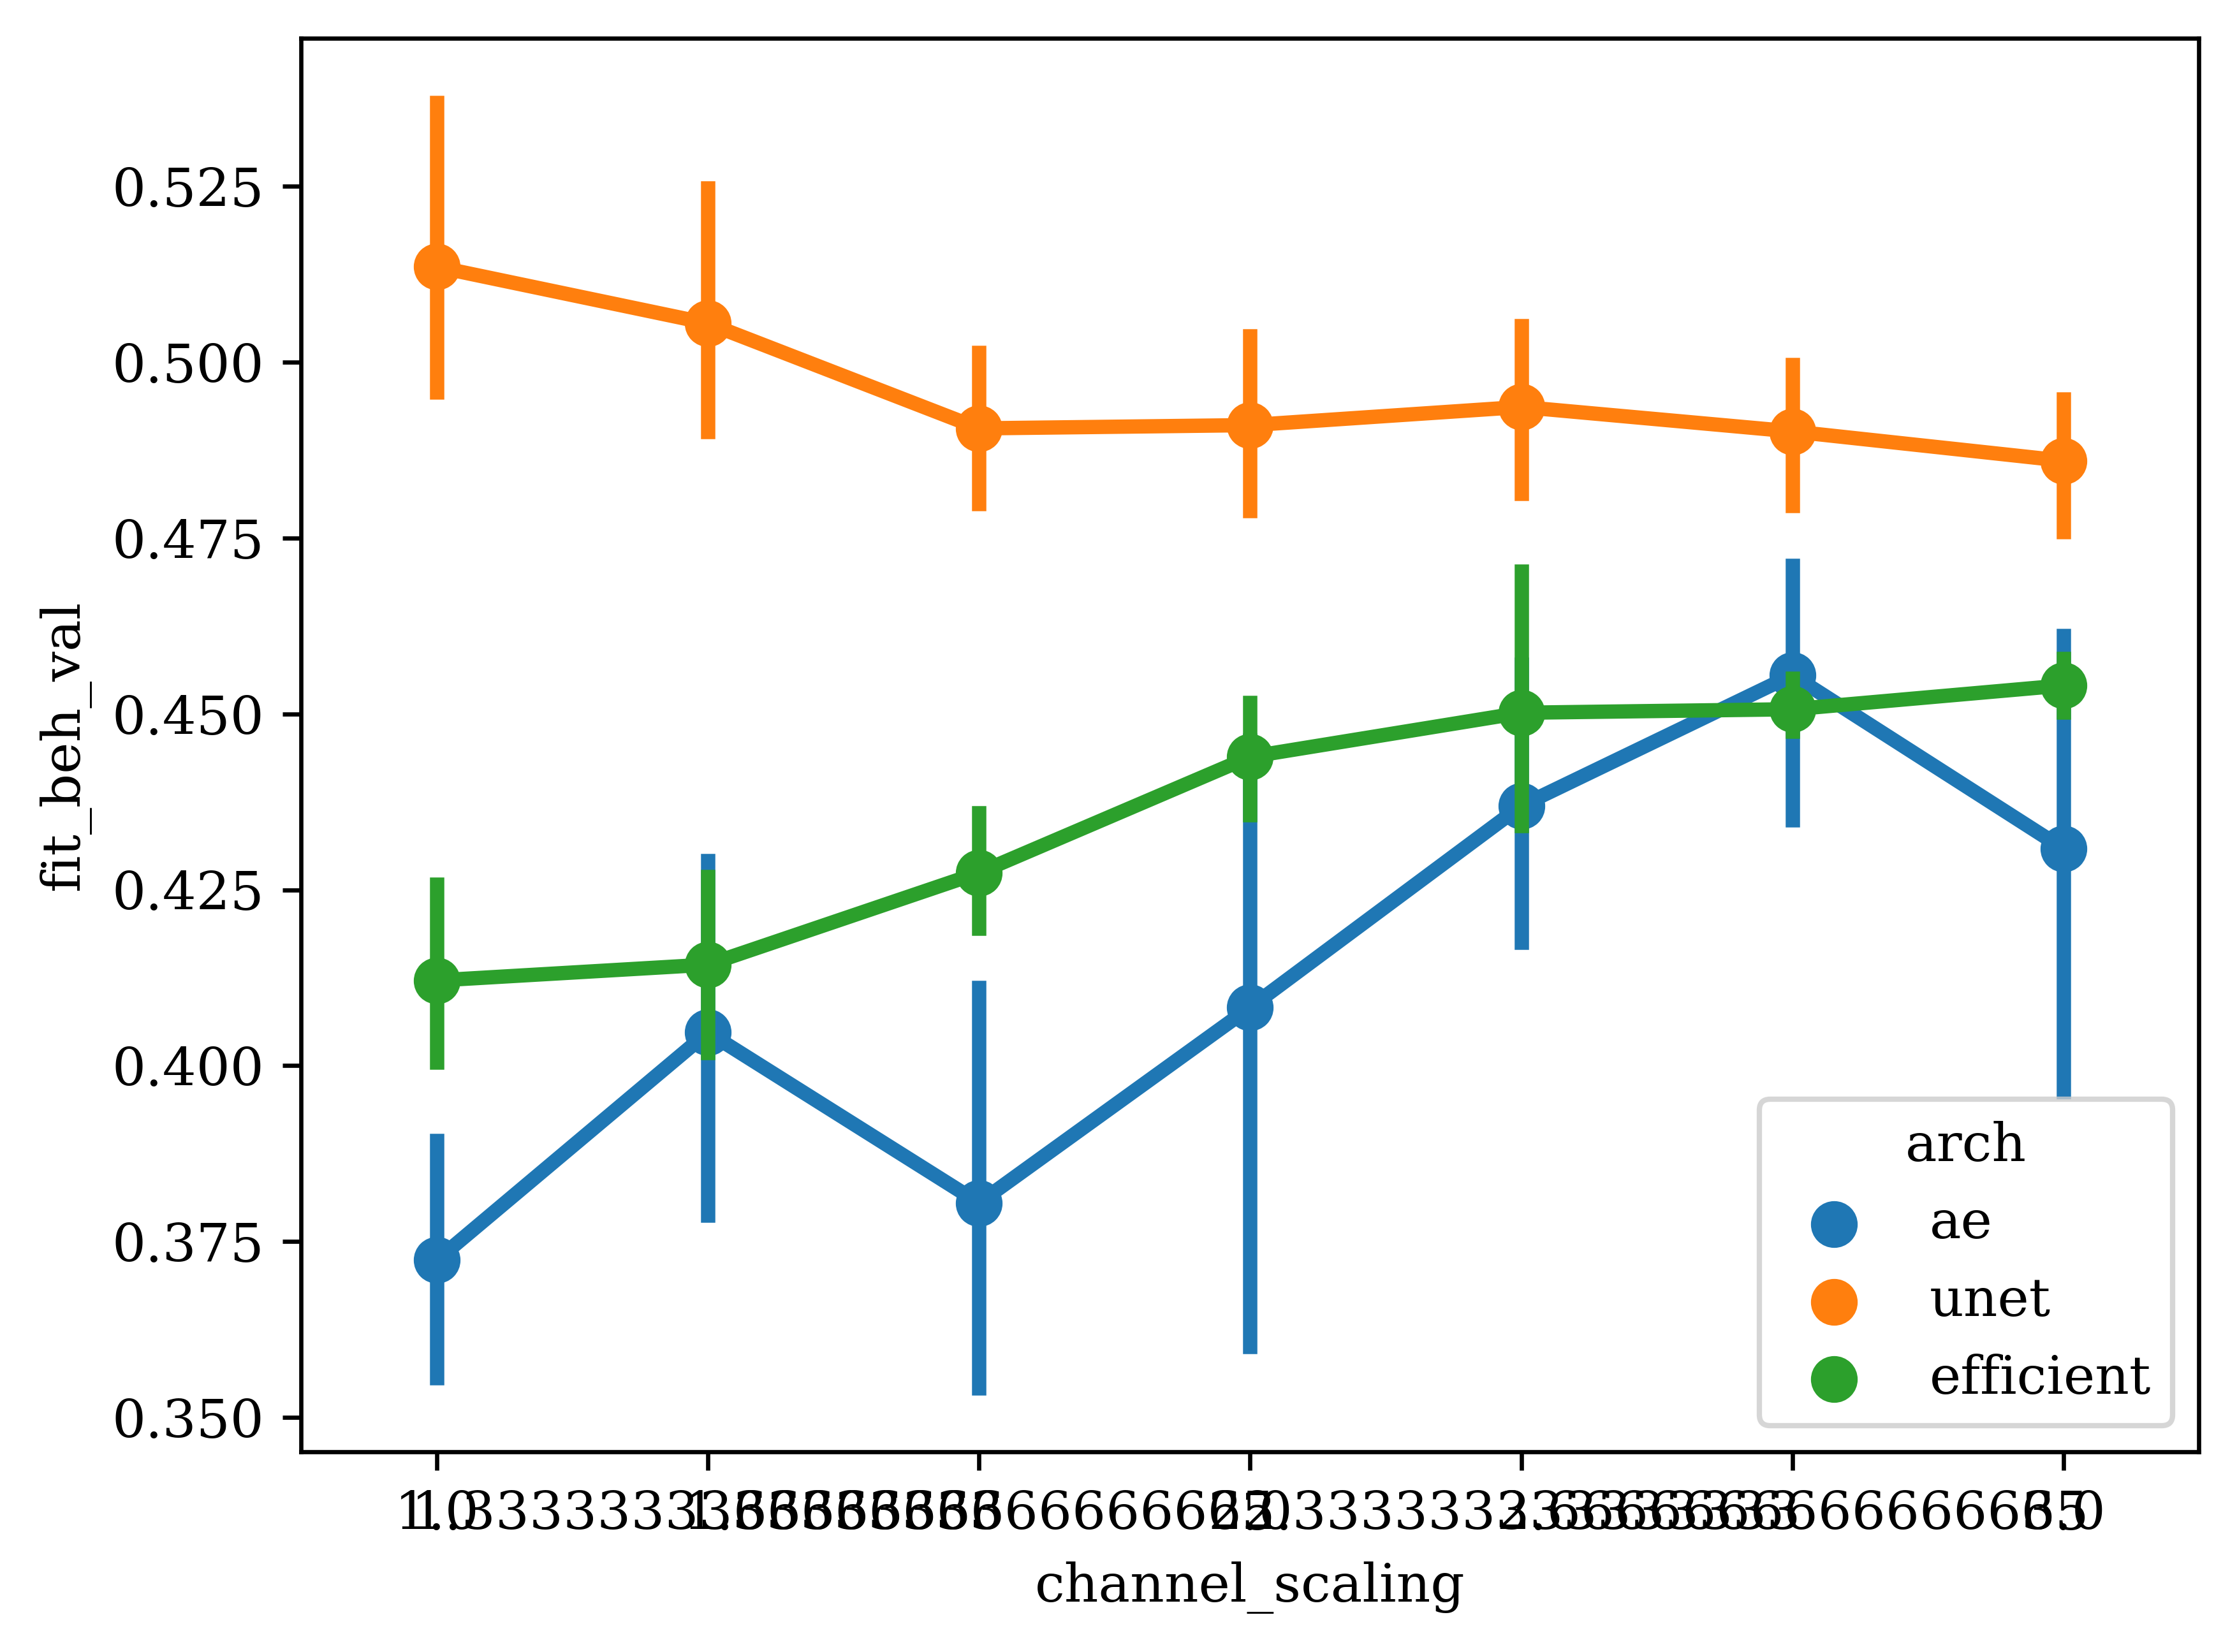

In [35]:
sns.pointplot(data=results, x='channel_scaling', y='fit_beh_val', hue='arch')

<Axes: xlabel='depth_scaling', ylabel='mse'>

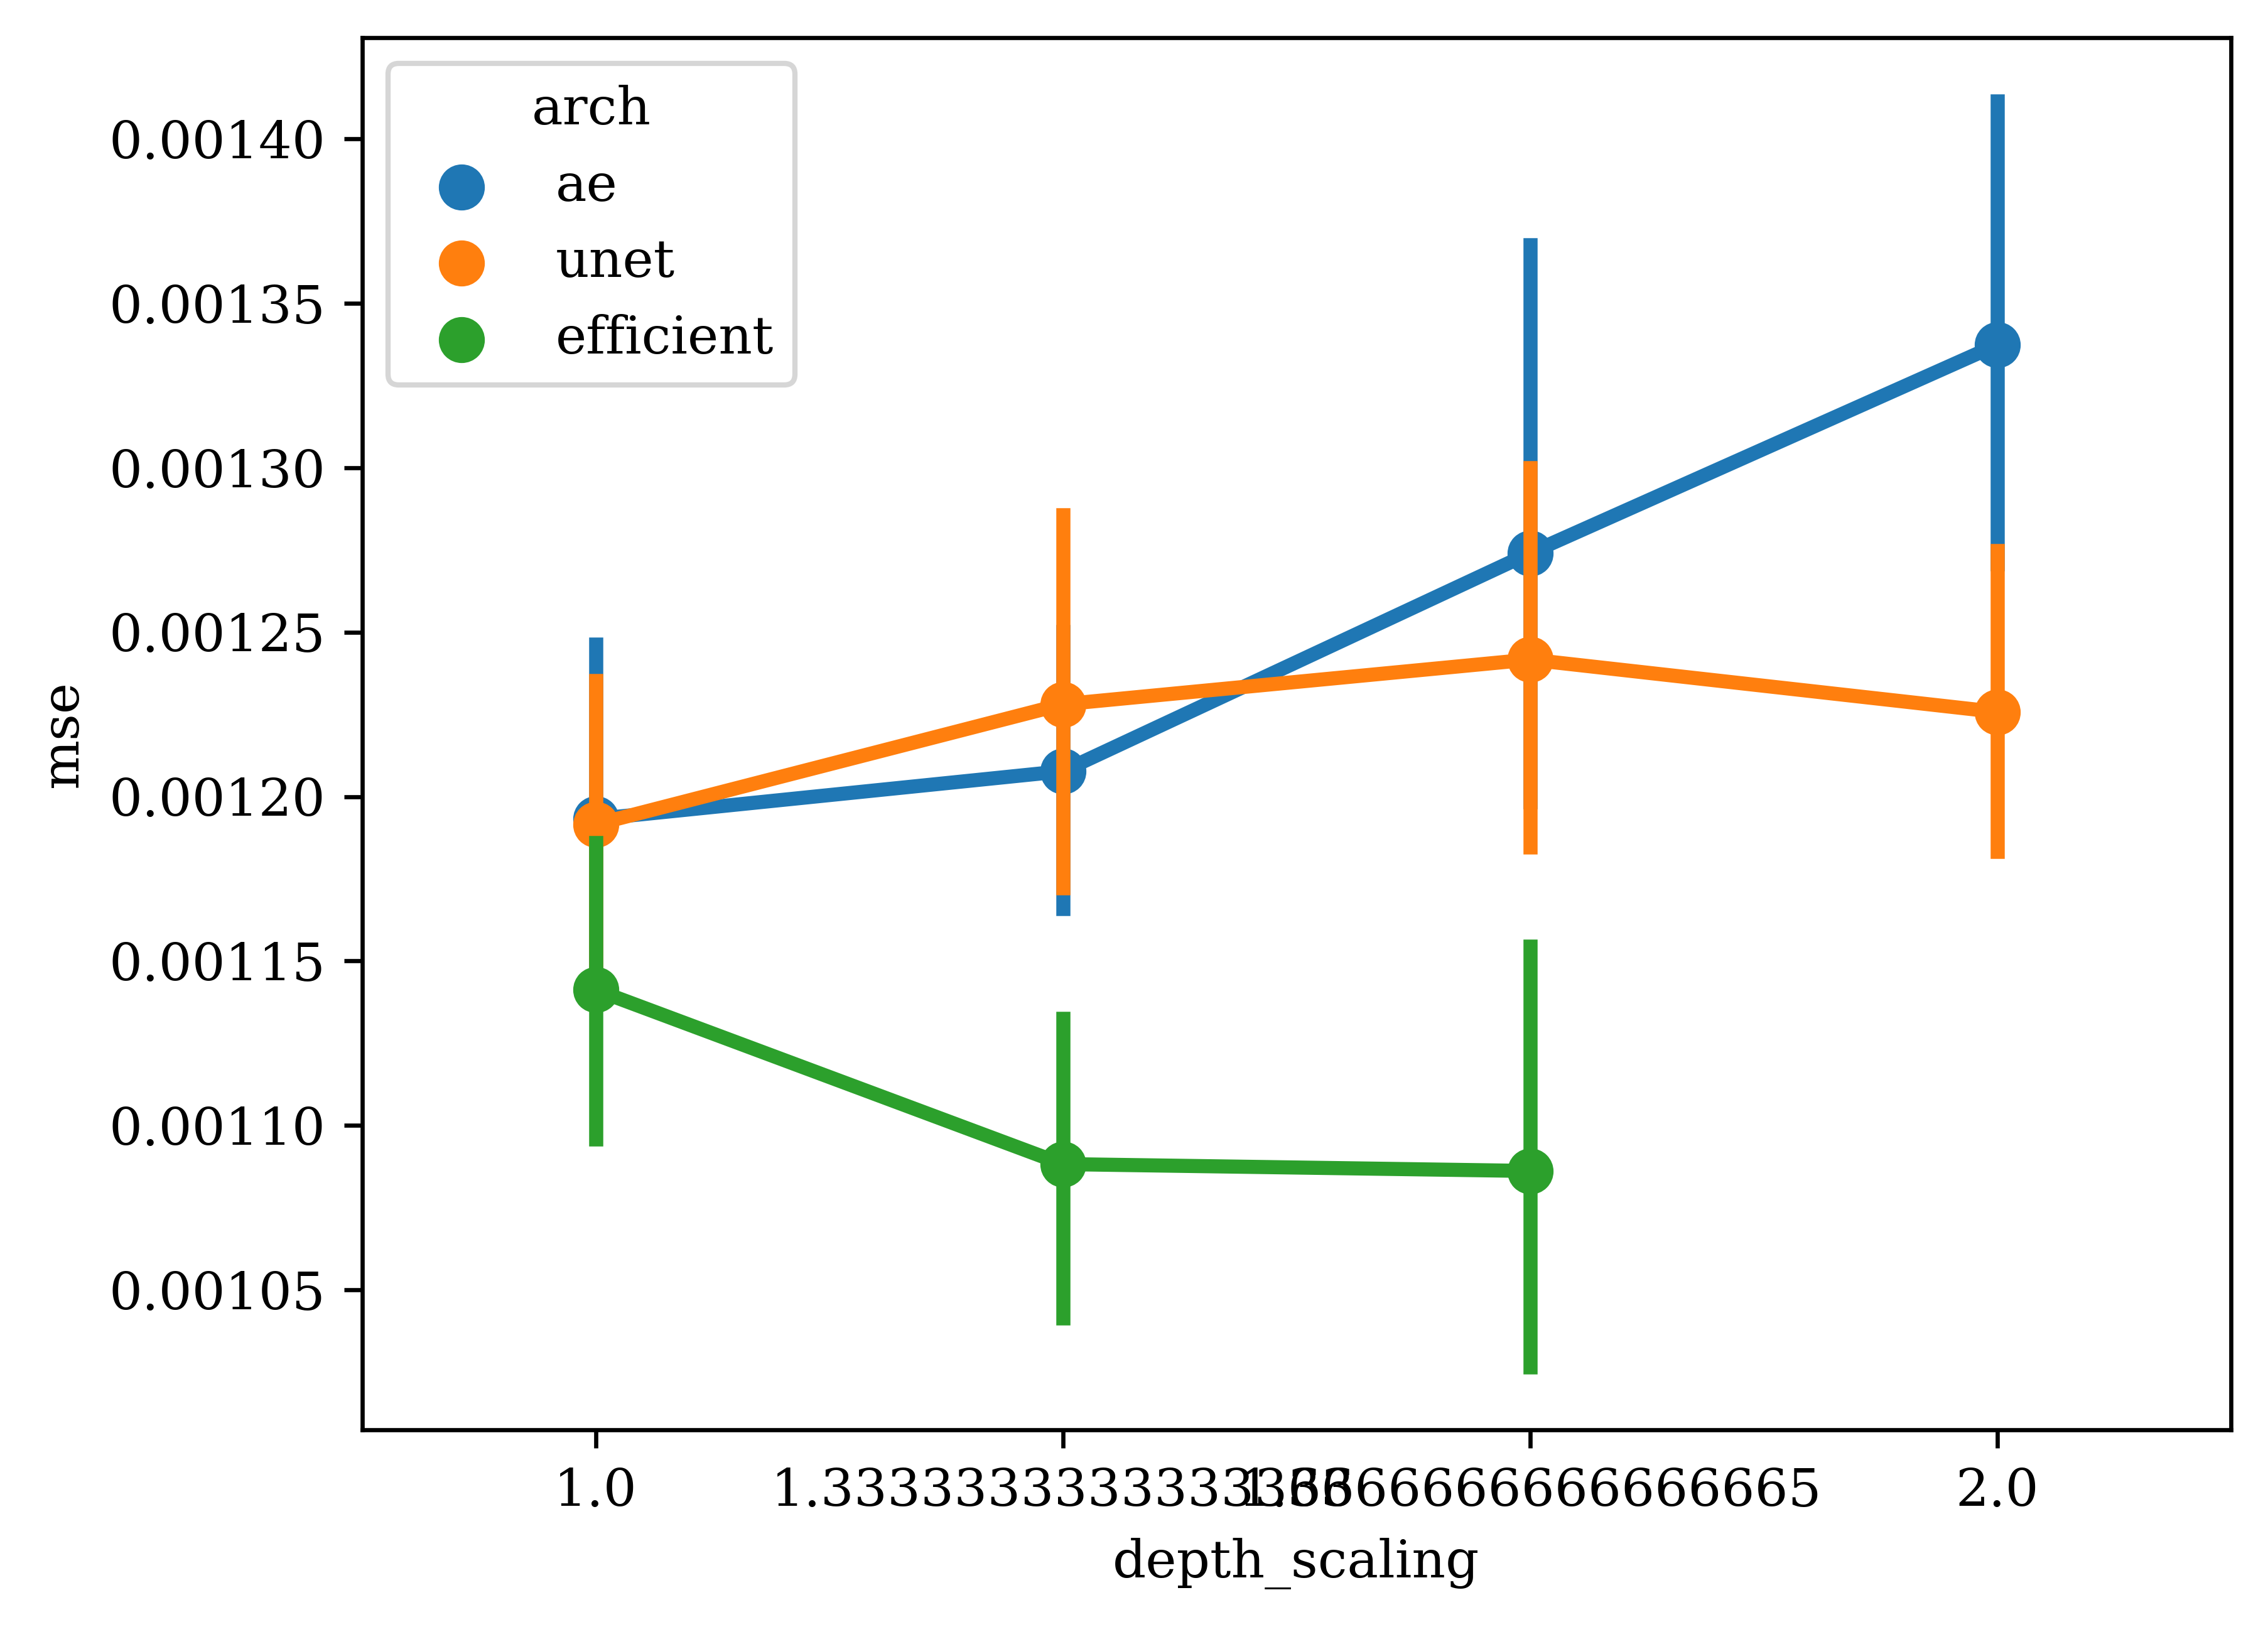

In [36]:
sns.pointplot(data=results, x='depth_scaling', y='mse', hue='arch')

<Axes: xlabel='depth_scaling', ylabel='fit_beh_val'>

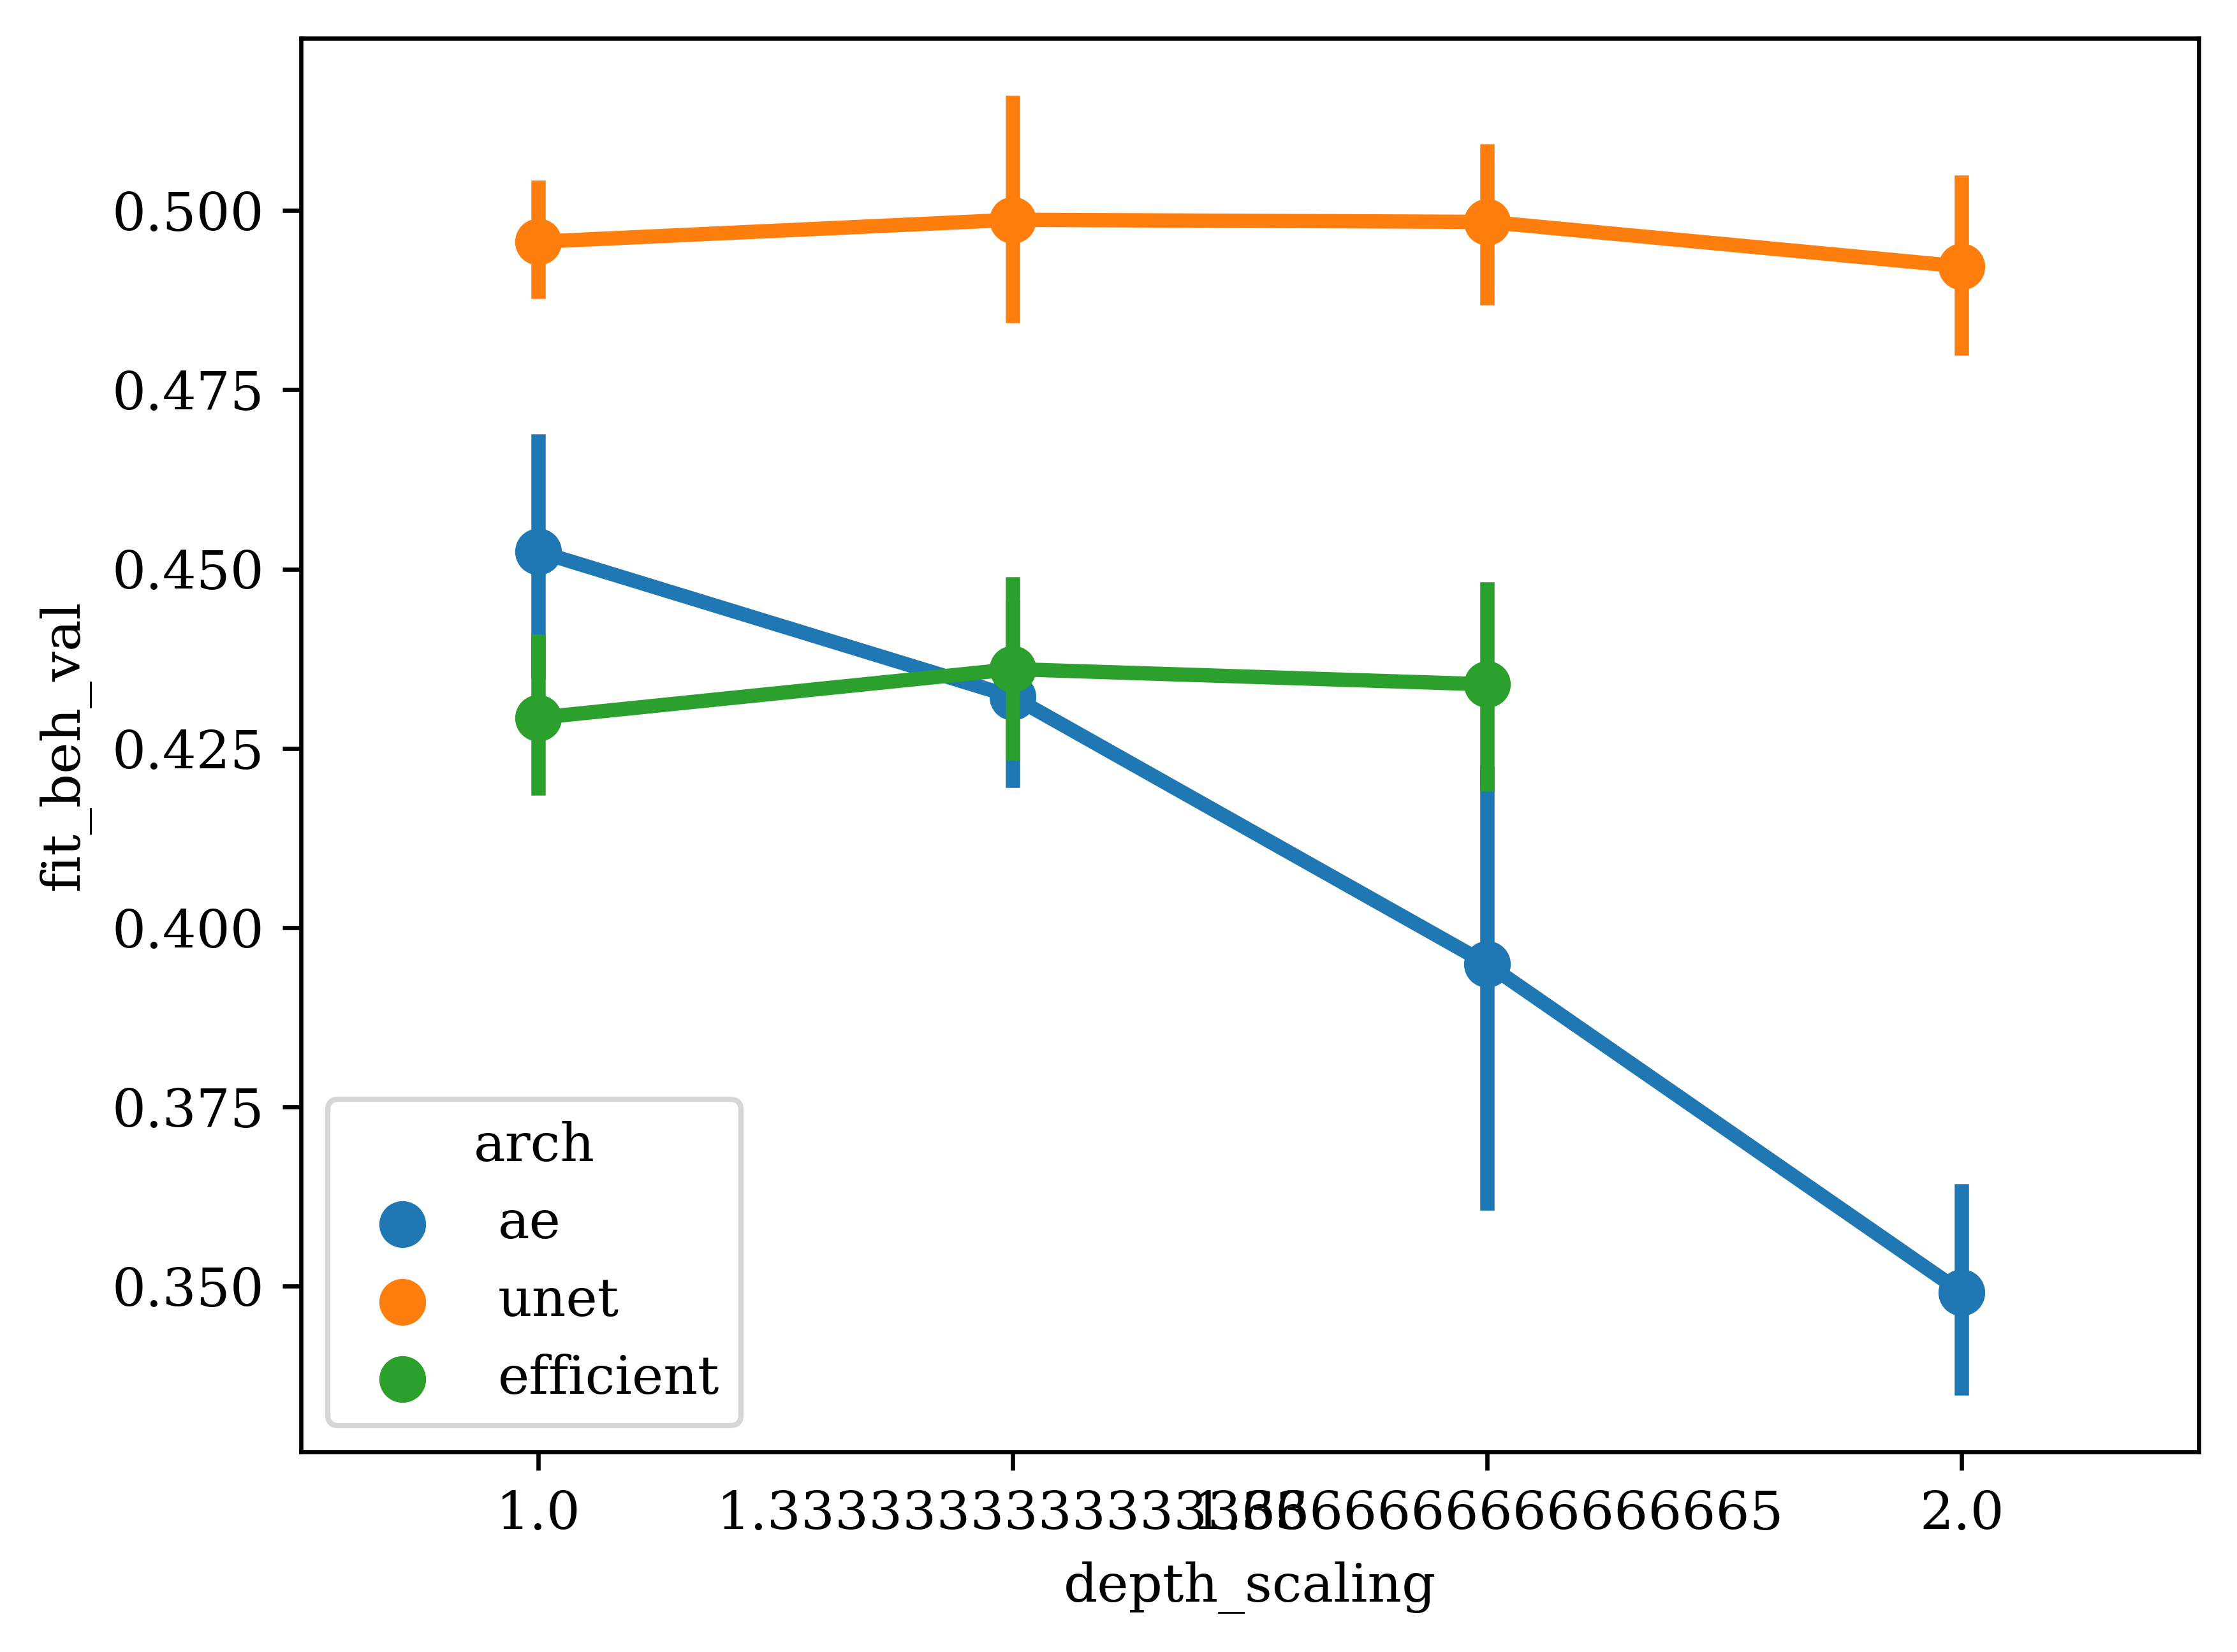

In [37]:
sns.pointplot(data=results, x='depth_scaling', y='fit_beh_val', hue='arch')

In [40]:
results = results.copy()
results['channel_scaling'] = results['channel_scaling'].round(2)
results['depth_scaling'] = results['depth_scaling'].round(2)

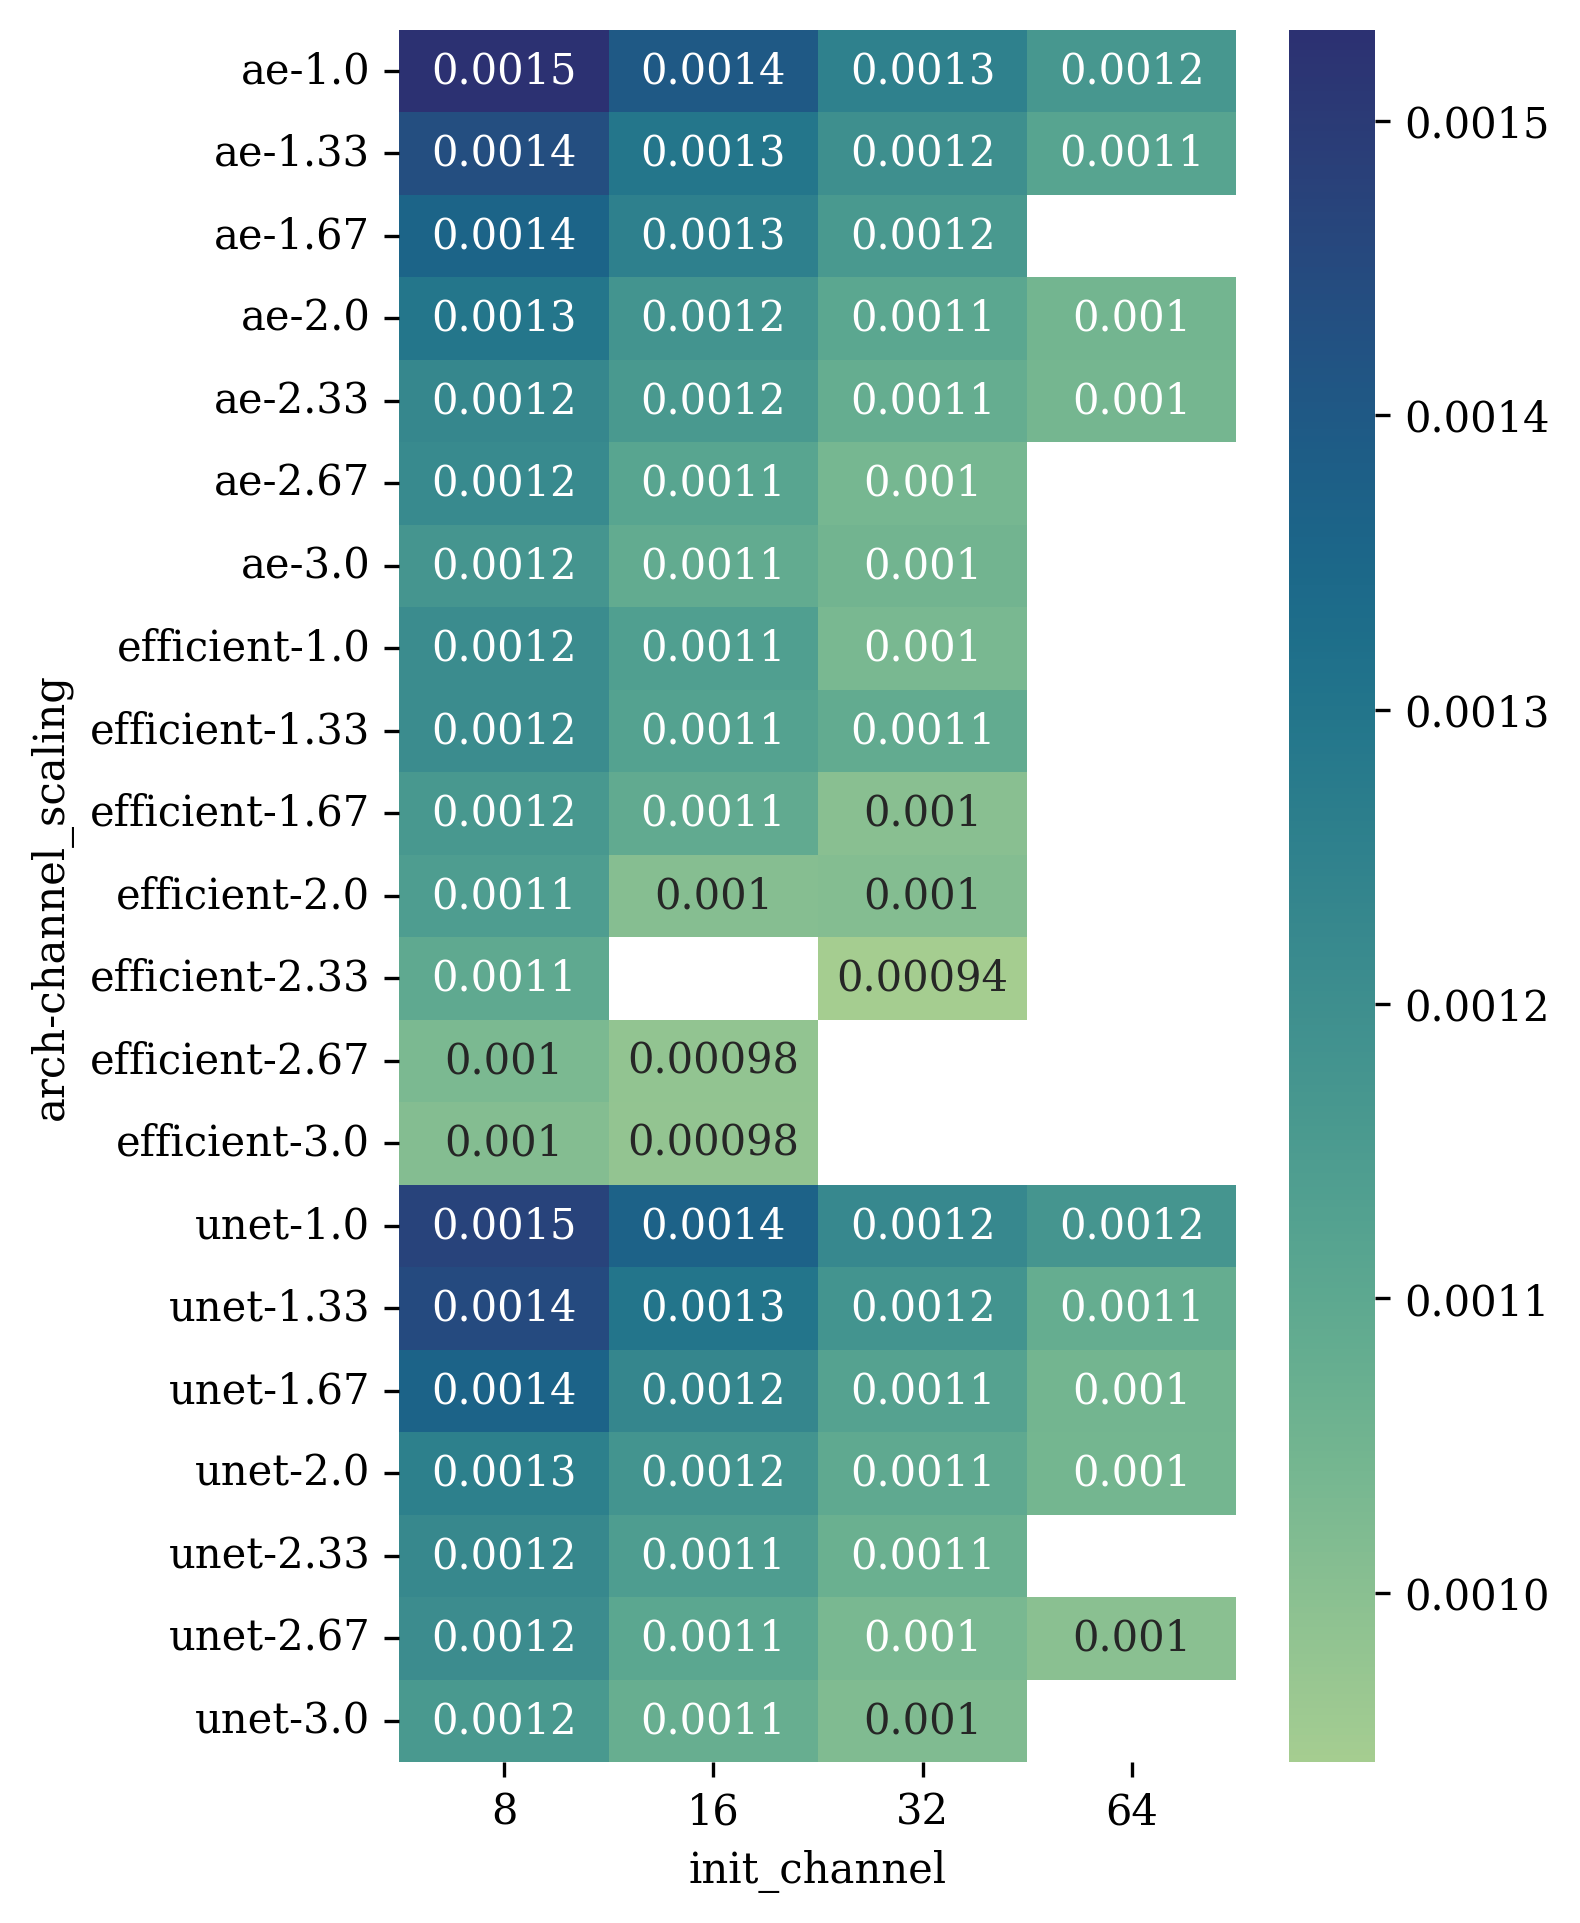

In [43]:
tbl = results.pivot_table(index=['arch', 'channel_scaling'], columns='init_channel', values='mse', aggfunc='min')

# for arch in ('ae', 'unet', 'efficient'):
fig = plt.figure(figsize=(4.5, 7.5))
fig.dpi = 150
ax = sns.heatmap(tbl, annot=True, cmap='crest', vmin=tbl.min().min(), vmax=tbl.max().max())
# ax.set_title(arch)

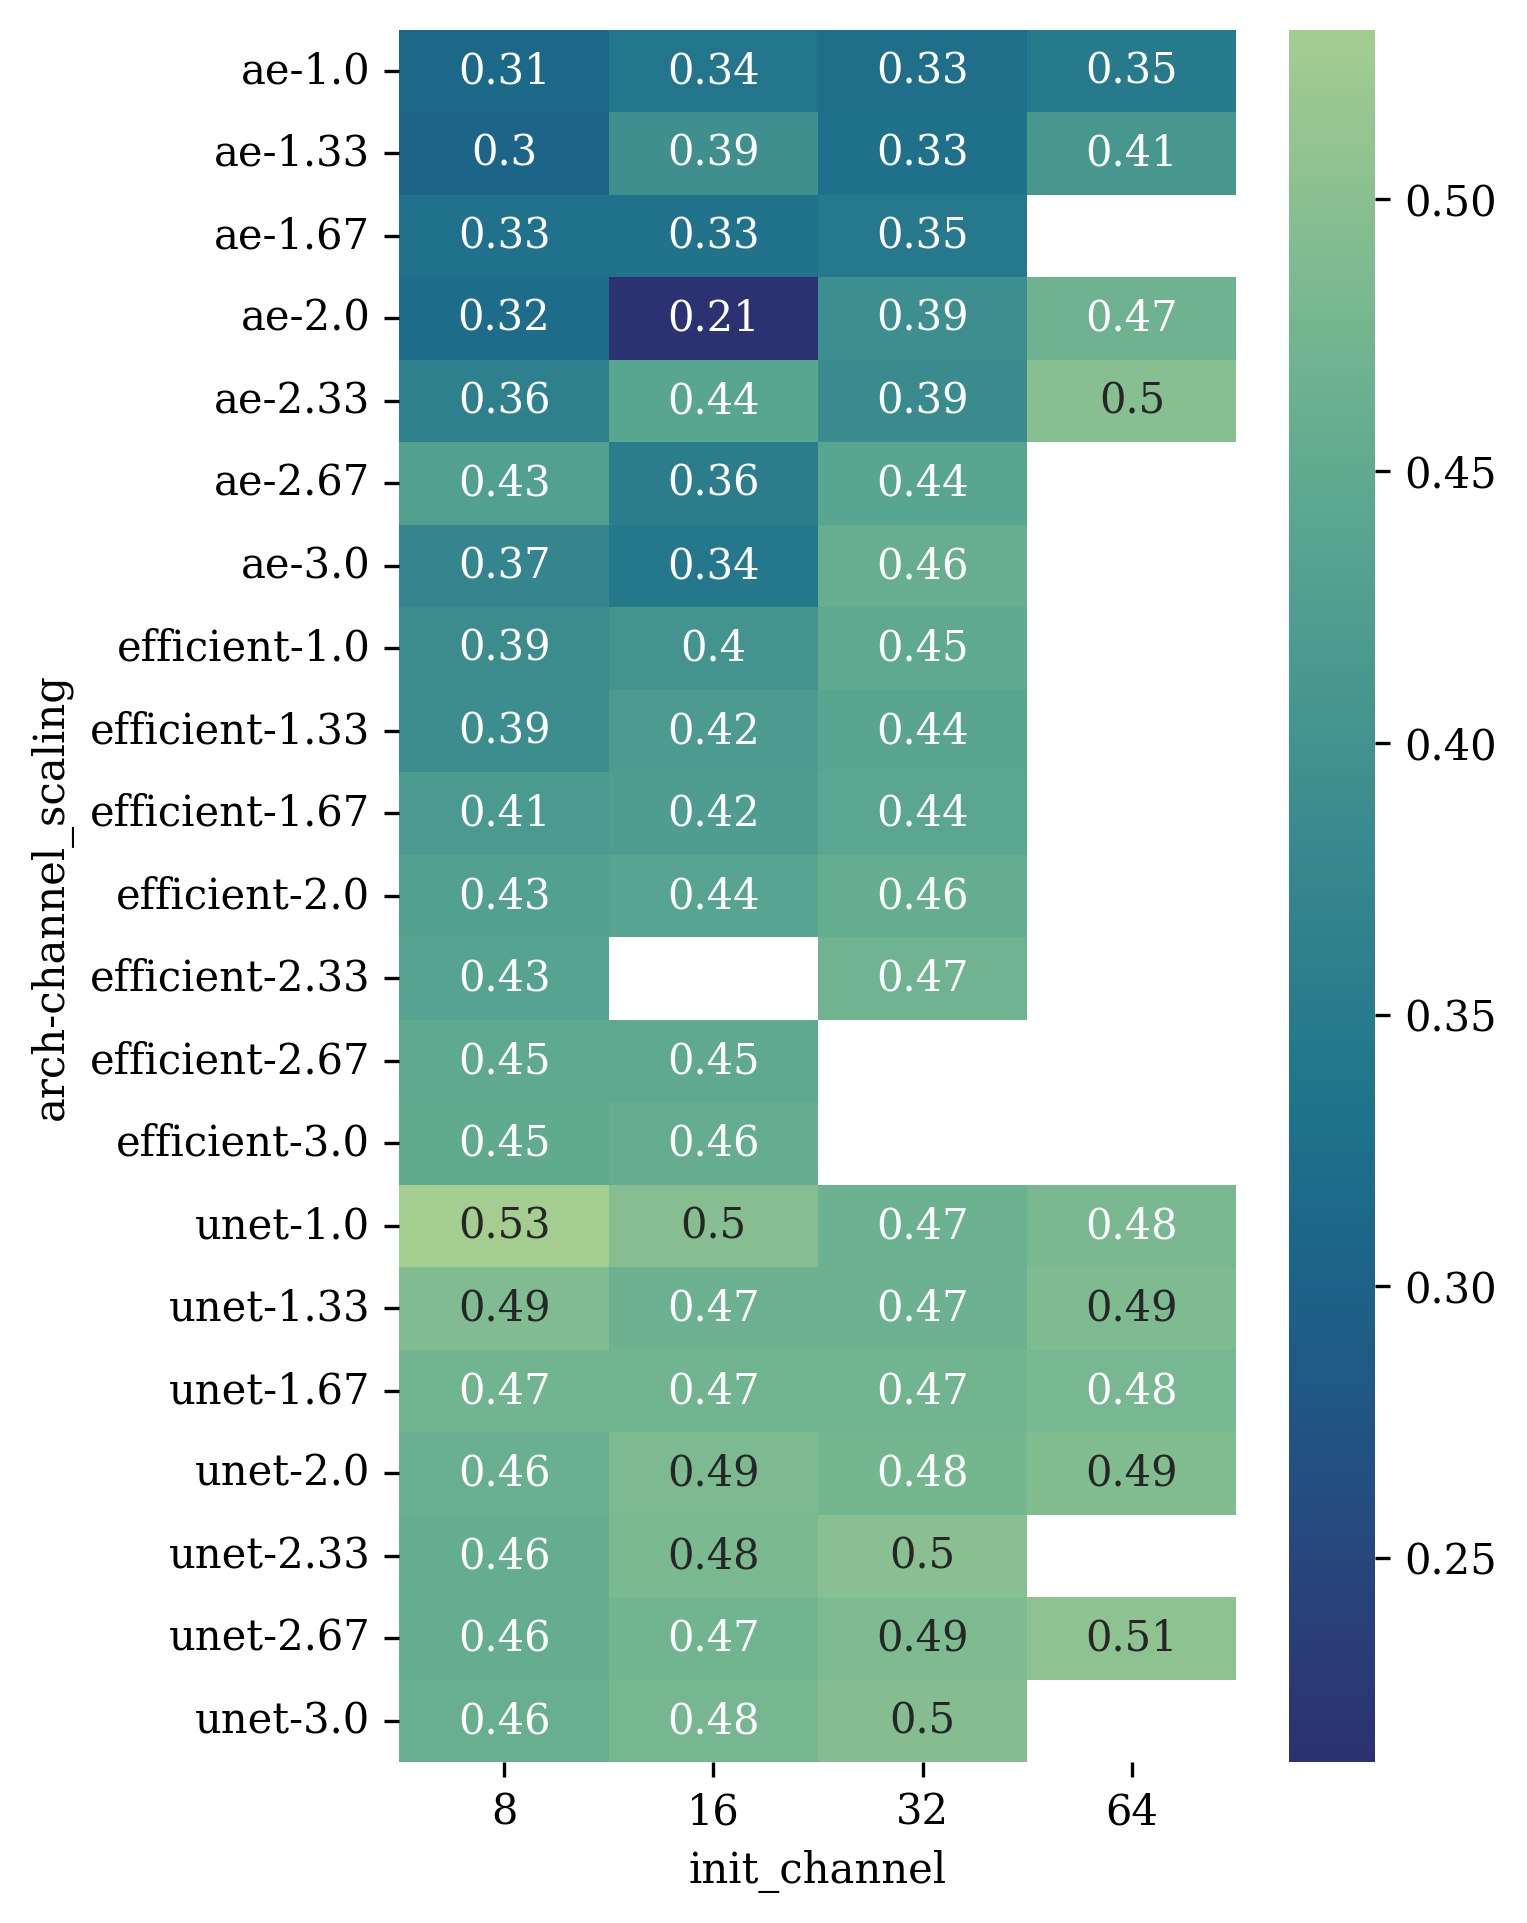

In [42]:
tbl = results.pivot_table(index=['arch', 'channel_scaling'], columns='init_channel', values='fit_beh_val', aggfunc='min')

fig = plt.figure(figsize=(4.5, 7.5))
fig.dpi = 150
ax = sns.heatmap(tbl, annot=True, cmap='crest_r', vmin=tbl.min().min(), vmax=tbl.max().max())
# ax.set_title(arch)

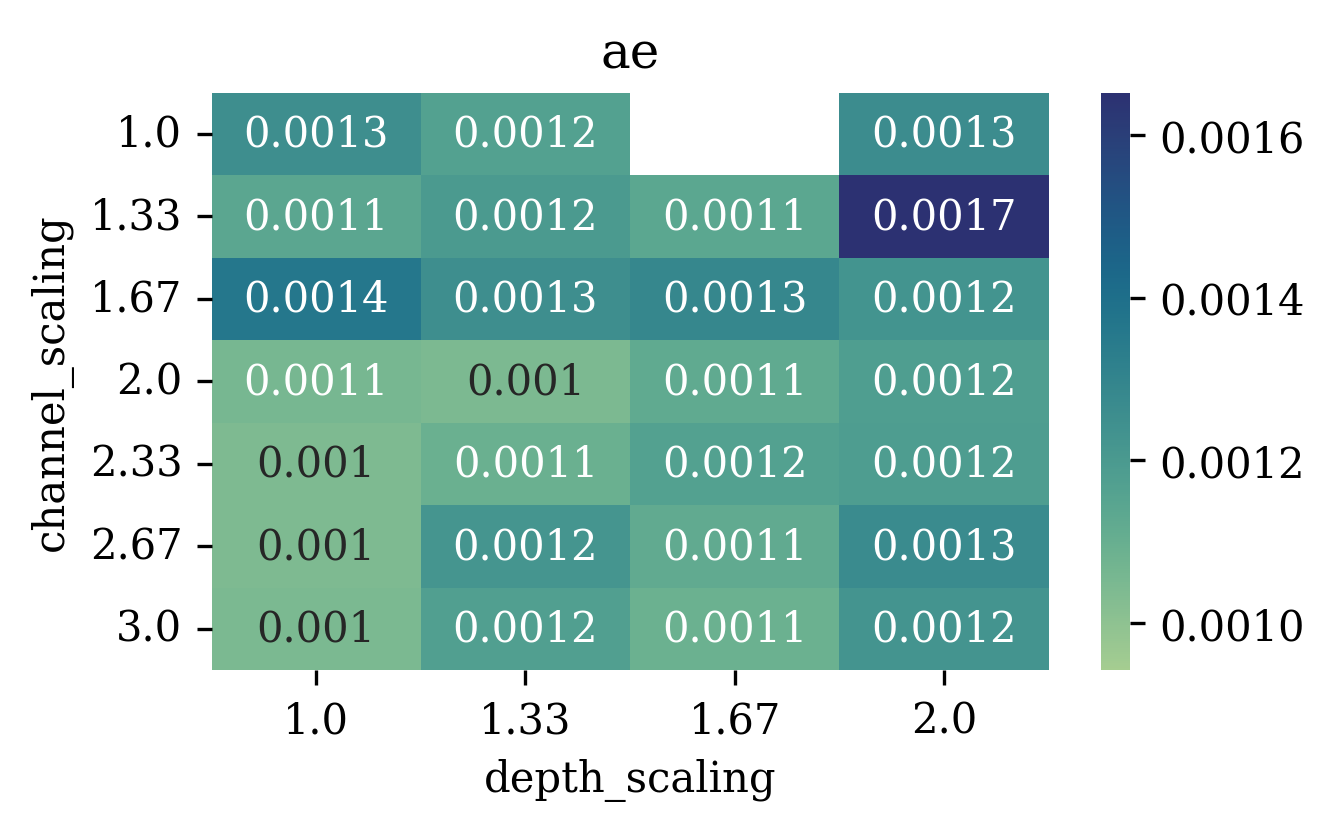

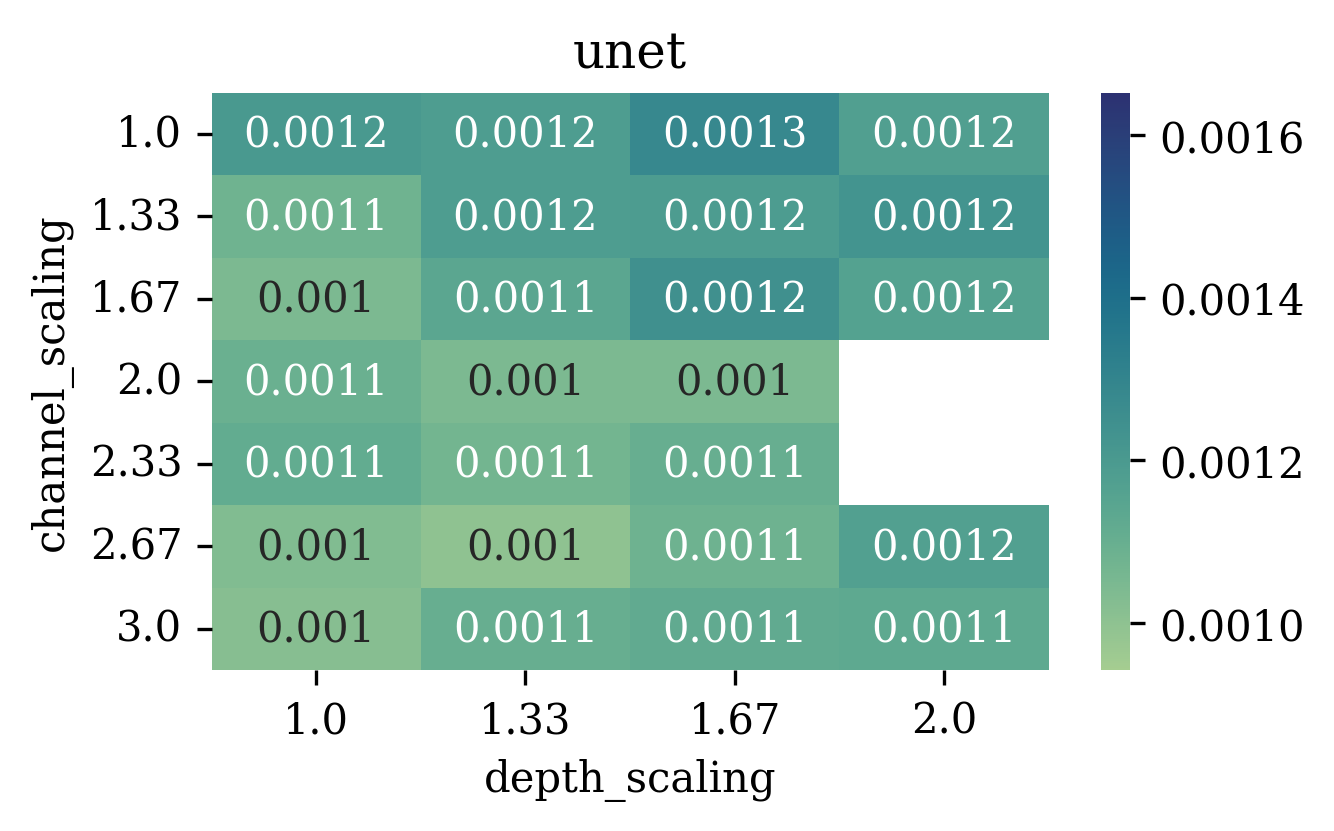

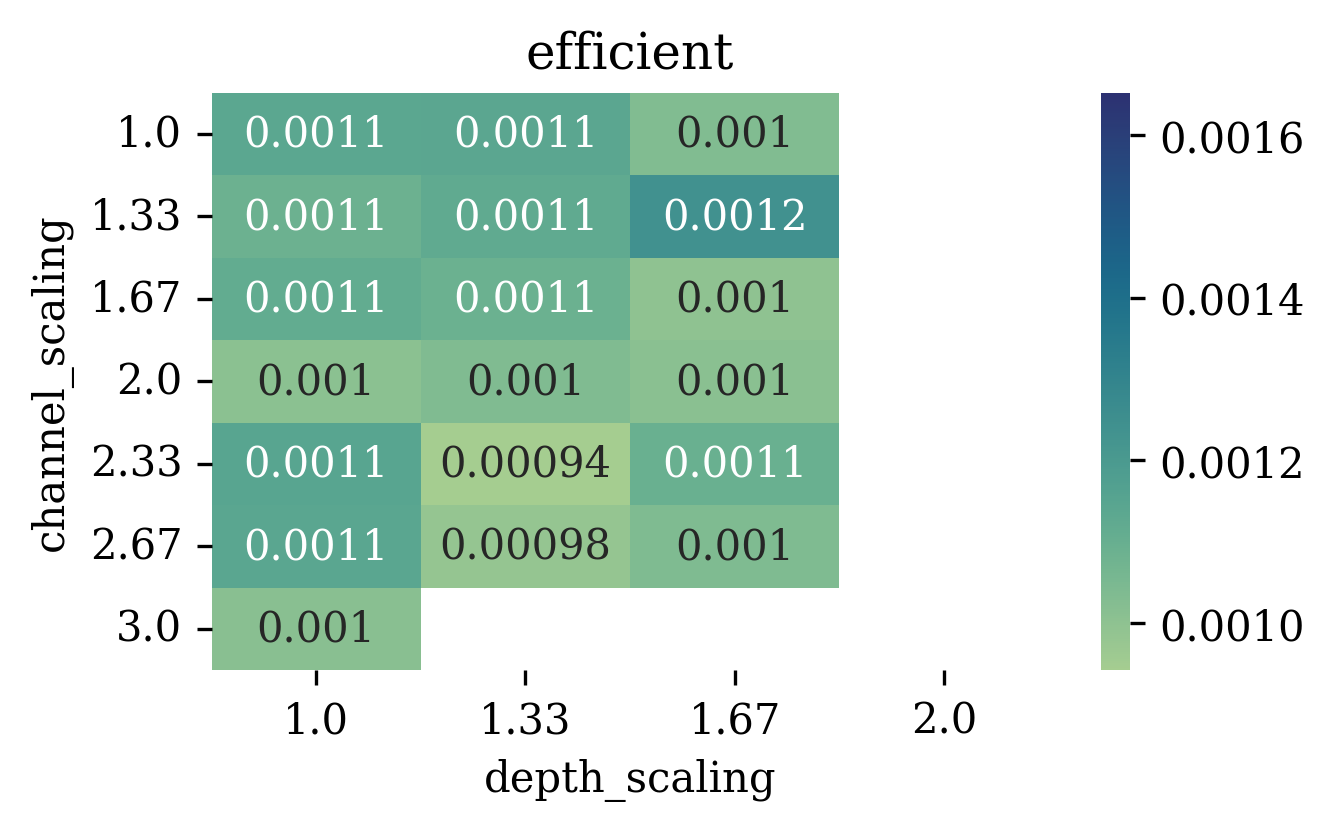

In [52]:
tbl = results.pivot_table(index=['arch', 'channel_scaling'], columns='depth_scaling', values='mse', aggfunc='min')

for arch in ('ae', 'unet', 'efficient'):
    fig = plt.figure(figsize=(4.5, 2.5))
    fig.dpi = 150
    ax = sns.heatmap(tbl.loc[arch], annot=True, cmap='crest', vmin=tbl.min().min(), vmax=tbl.max().max())
    ax.set_title(arch)

## Validation r2's

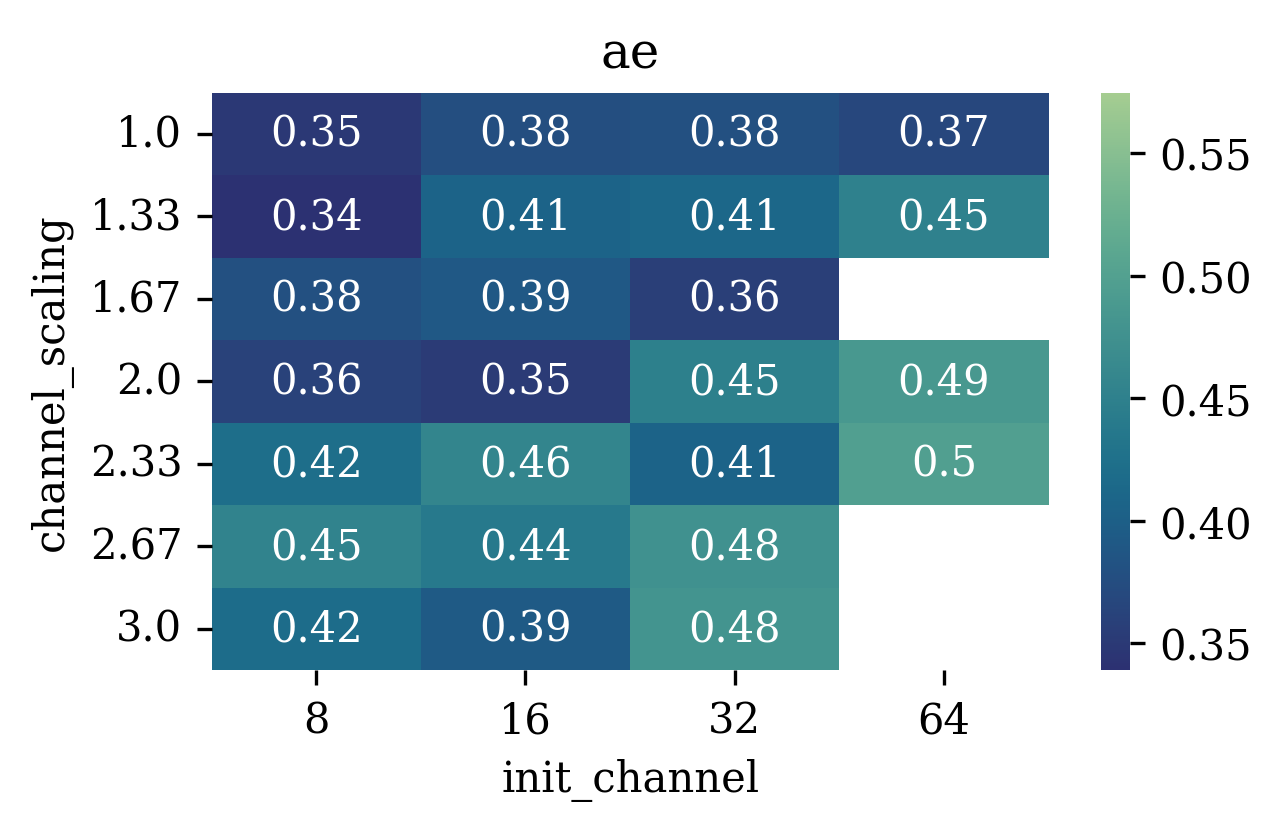

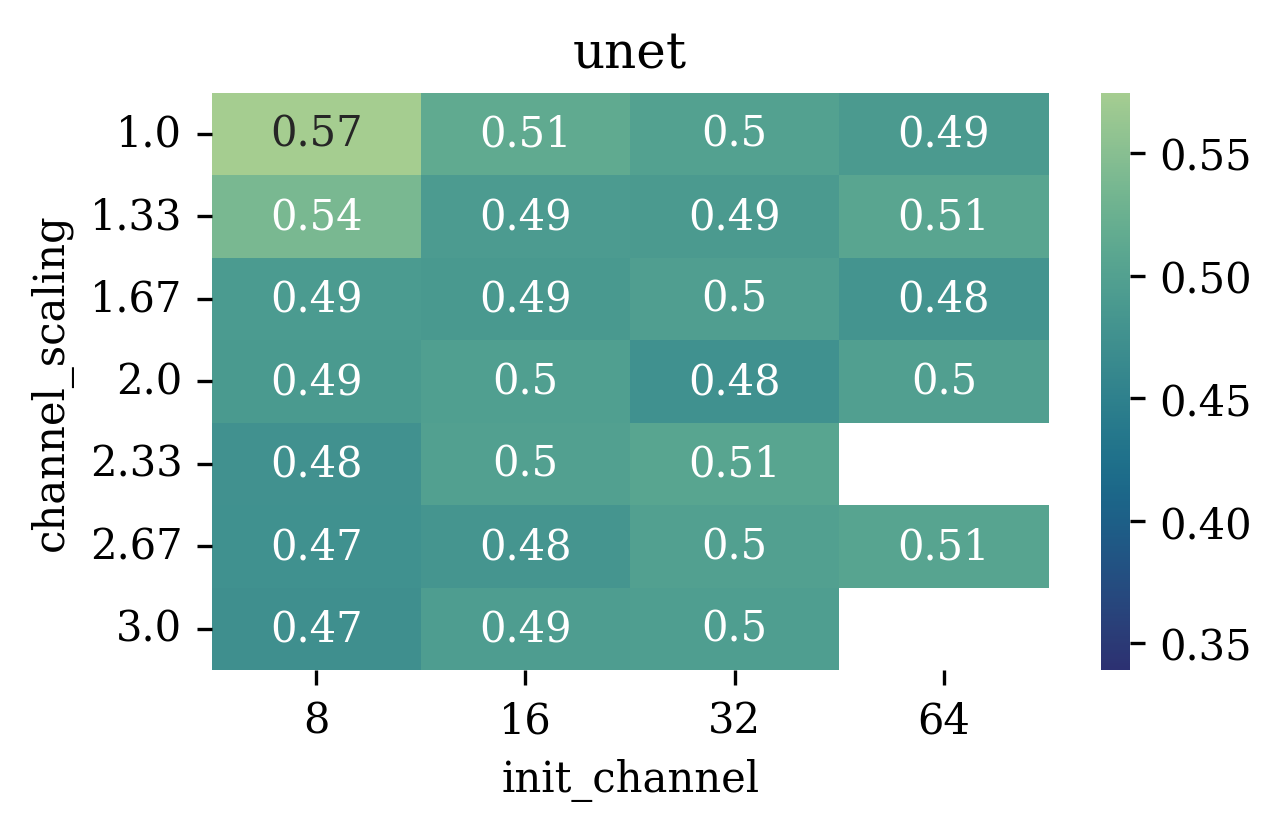

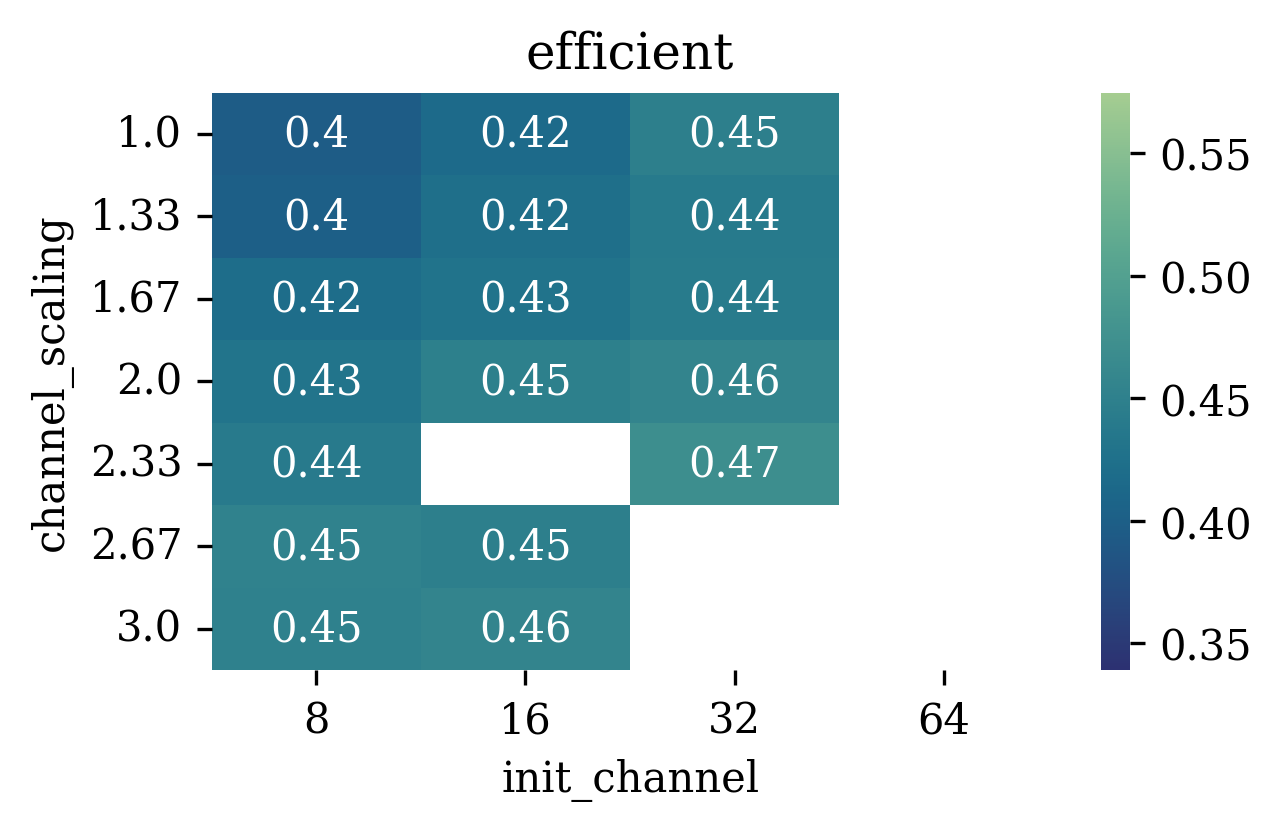

In [48]:
tbl = results.pivot_table(index=['arch', 'channel_scaling'], columns='init_channel', values='fit_beh_val')

for arch in ('ae', 'unet', 'efficient'):
    fig = plt.figure(figsize=(4.5, 2.5))
    fig.dpi = 150
    ax = sns.heatmap(tbl.loc[arch], annot=True, cmap='crest_r', vmin=tbl.min().min(), vmax=tbl.max().max())
    ax.set_title(arch)

## Explore behavior validation across training

In [44]:
tmp_df = pd.read_csv('/n/groups/datta/win/longtogeny/size_norm/models/testing/size_norm_scan/version_4/metrics.csv')
# tmp_df = pd.read_csv('/n/groups/datta/win/longtogeny/size_norm/models/testing/size_norm_scan/version_6/metrics.csv')

In [45]:
tmp_df.dropna(subset=['val_r2'])

train_loss  epoch   step  val_loss    val_r2  heldout_r2
10          NaN      0    461       NaN  0.766111    0.542647
62          NaN      5   2771       NaN  0.749124    0.456162
114         NaN     10   5081       NaN  0.696354    0.399129
166         NaN     15   7391       NaN  0.648917    0.345919
219         NaN     20   9701       NaN  0.630059    0.324149
271         NaN     25  12011       NaN  0.587836    0.270222
323         NaN     30  14321       NaN  0.561875    0.252474
375         NaN     35  16631       NaN  0.598132    0.291114
427         NaN     40  18941       NaN  0.586210    0.279879
480         NaN     45  21251       NaN  0.567341    0.260193
532         NaN     50  23561       NaN  0.575118    0.263893
584         NaN     55  25871       NaN  0.547696    0.237976
636         NaN     60  28181       NaN  0.583622    0.282664
688         NaN     65  30491       NaN  0.556823    0.245950
741         NaN     70  32801       NaN  0.557719    0.251195
793         NaN     75  35111       NaN  0.586455    0.287423
845         NaN     80  37421       NaN  0.571033    0.265951

<Axes: xlabel='epoch'>

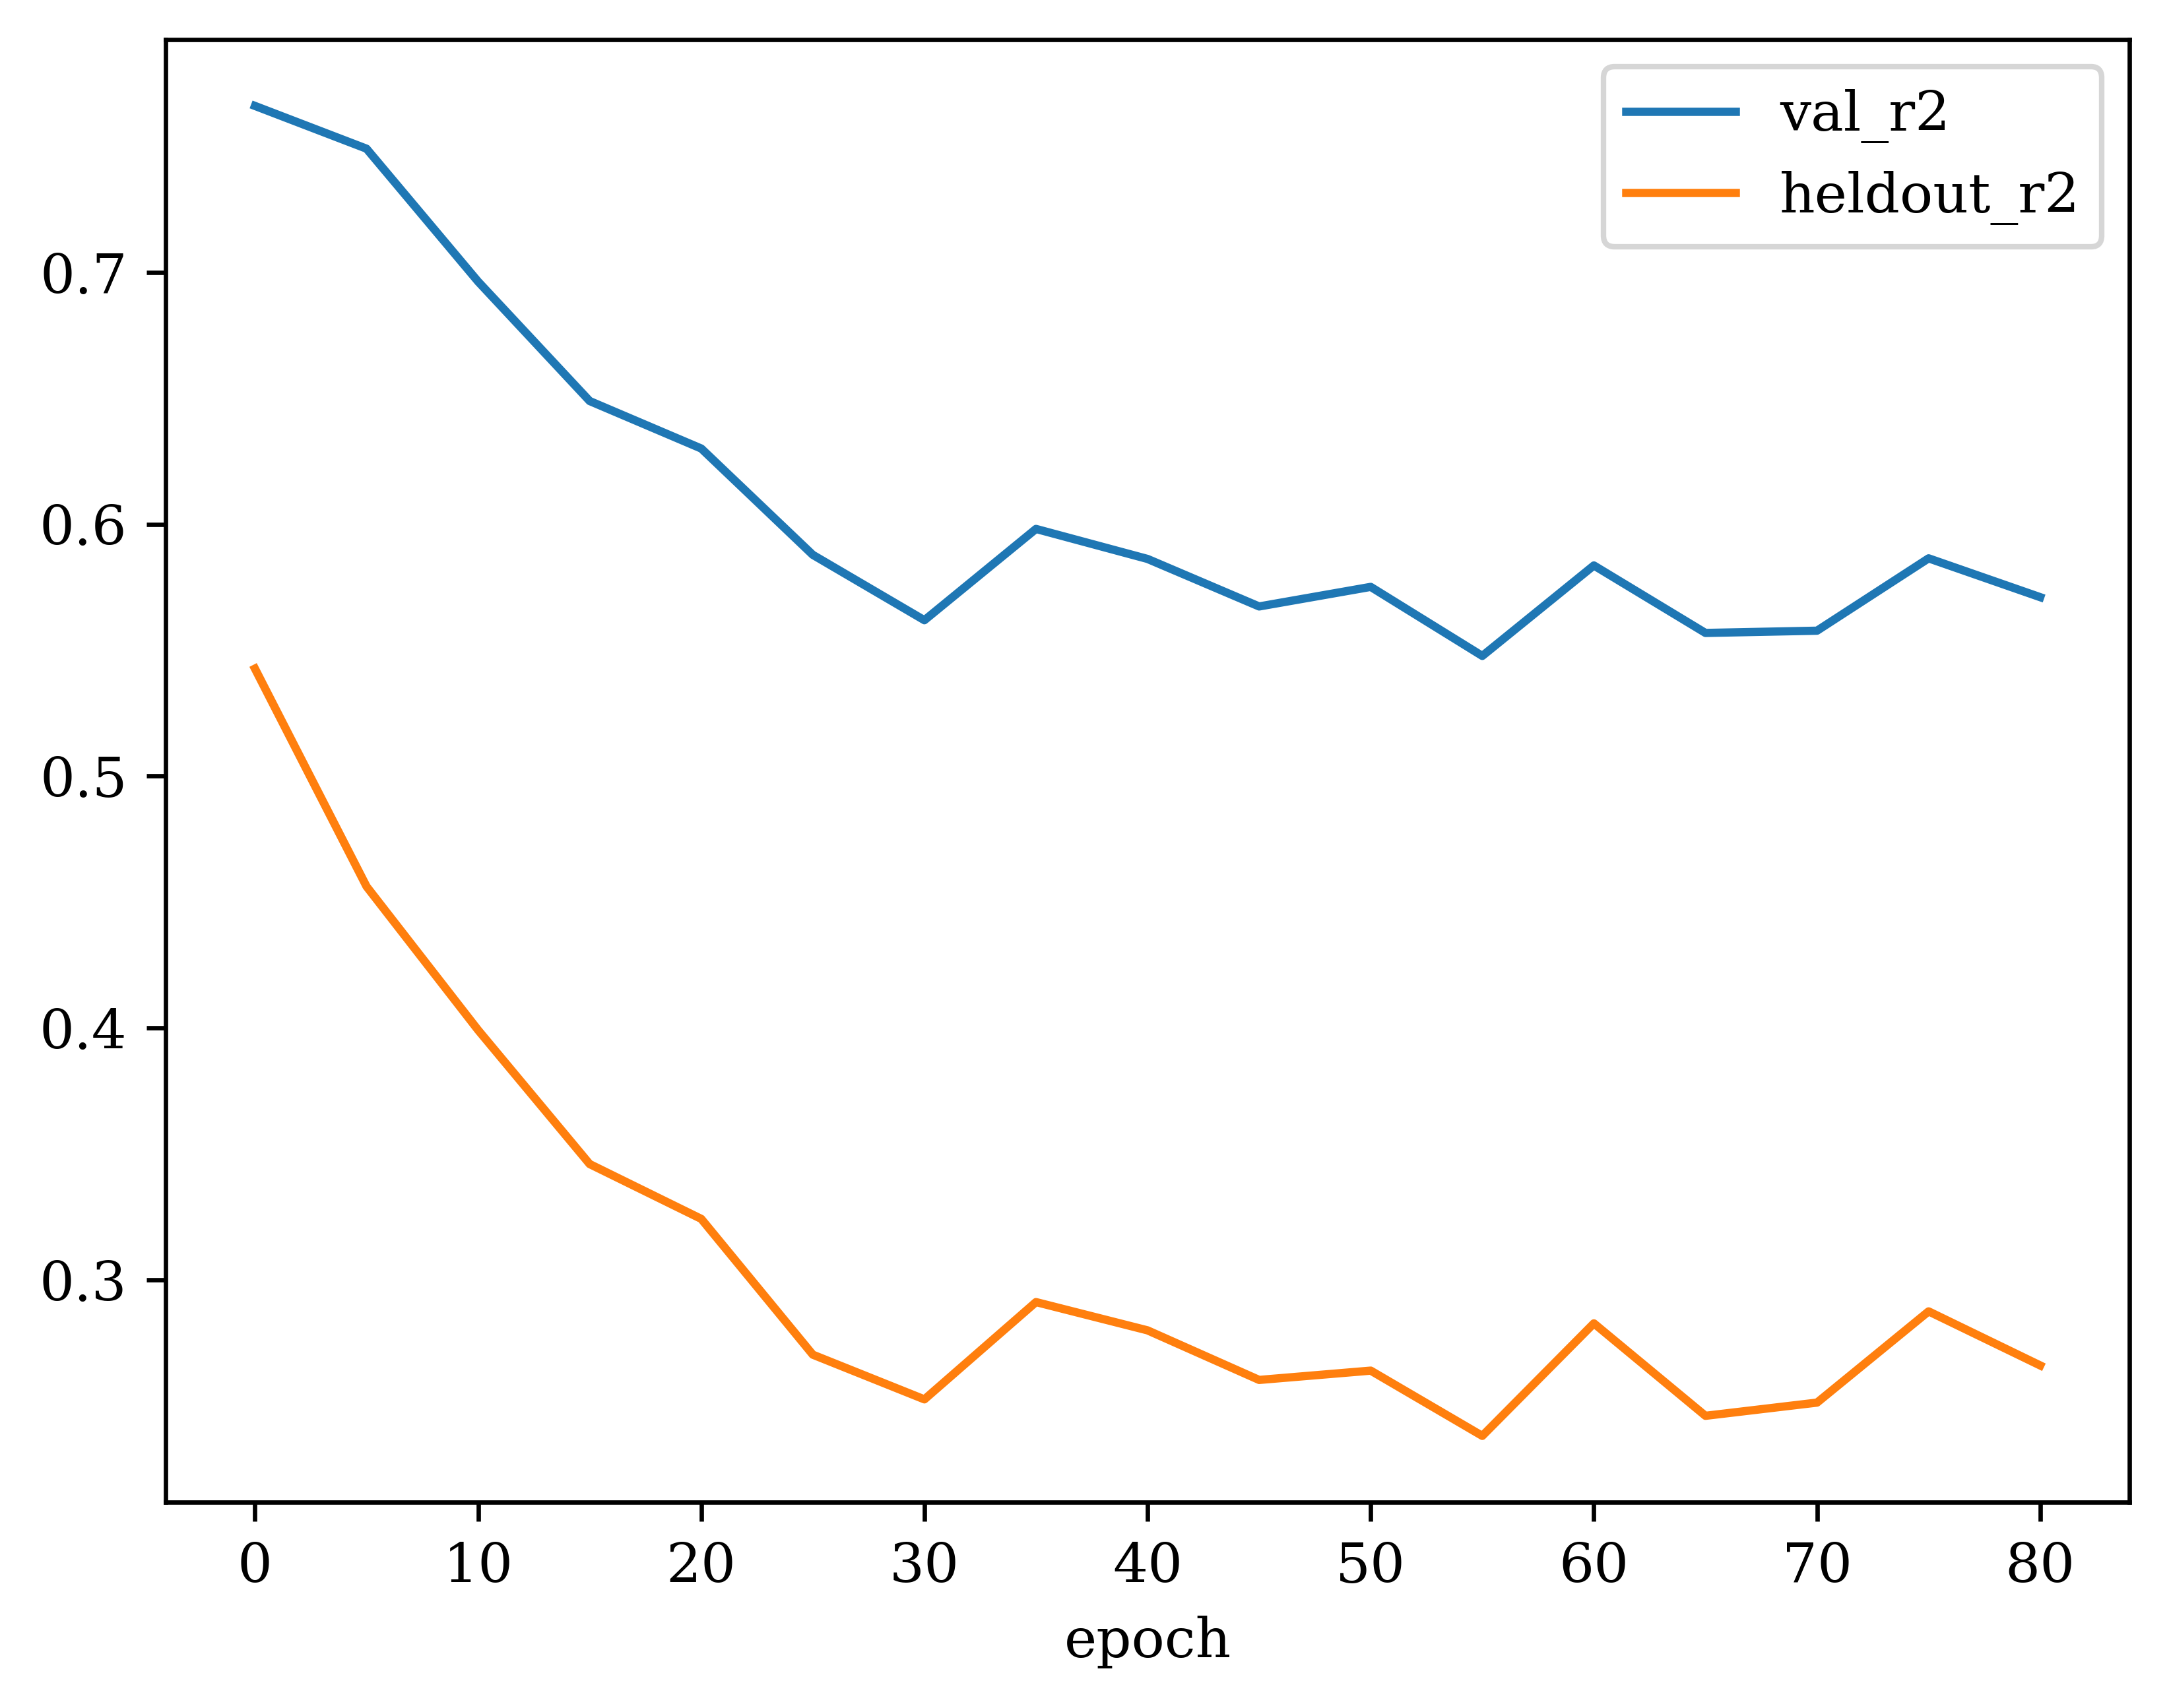

In [46]:
tmp_df.dropna(subset=['val_r2']).set_index('epoch')[['val_r2', 'heldout_r2']].plot()

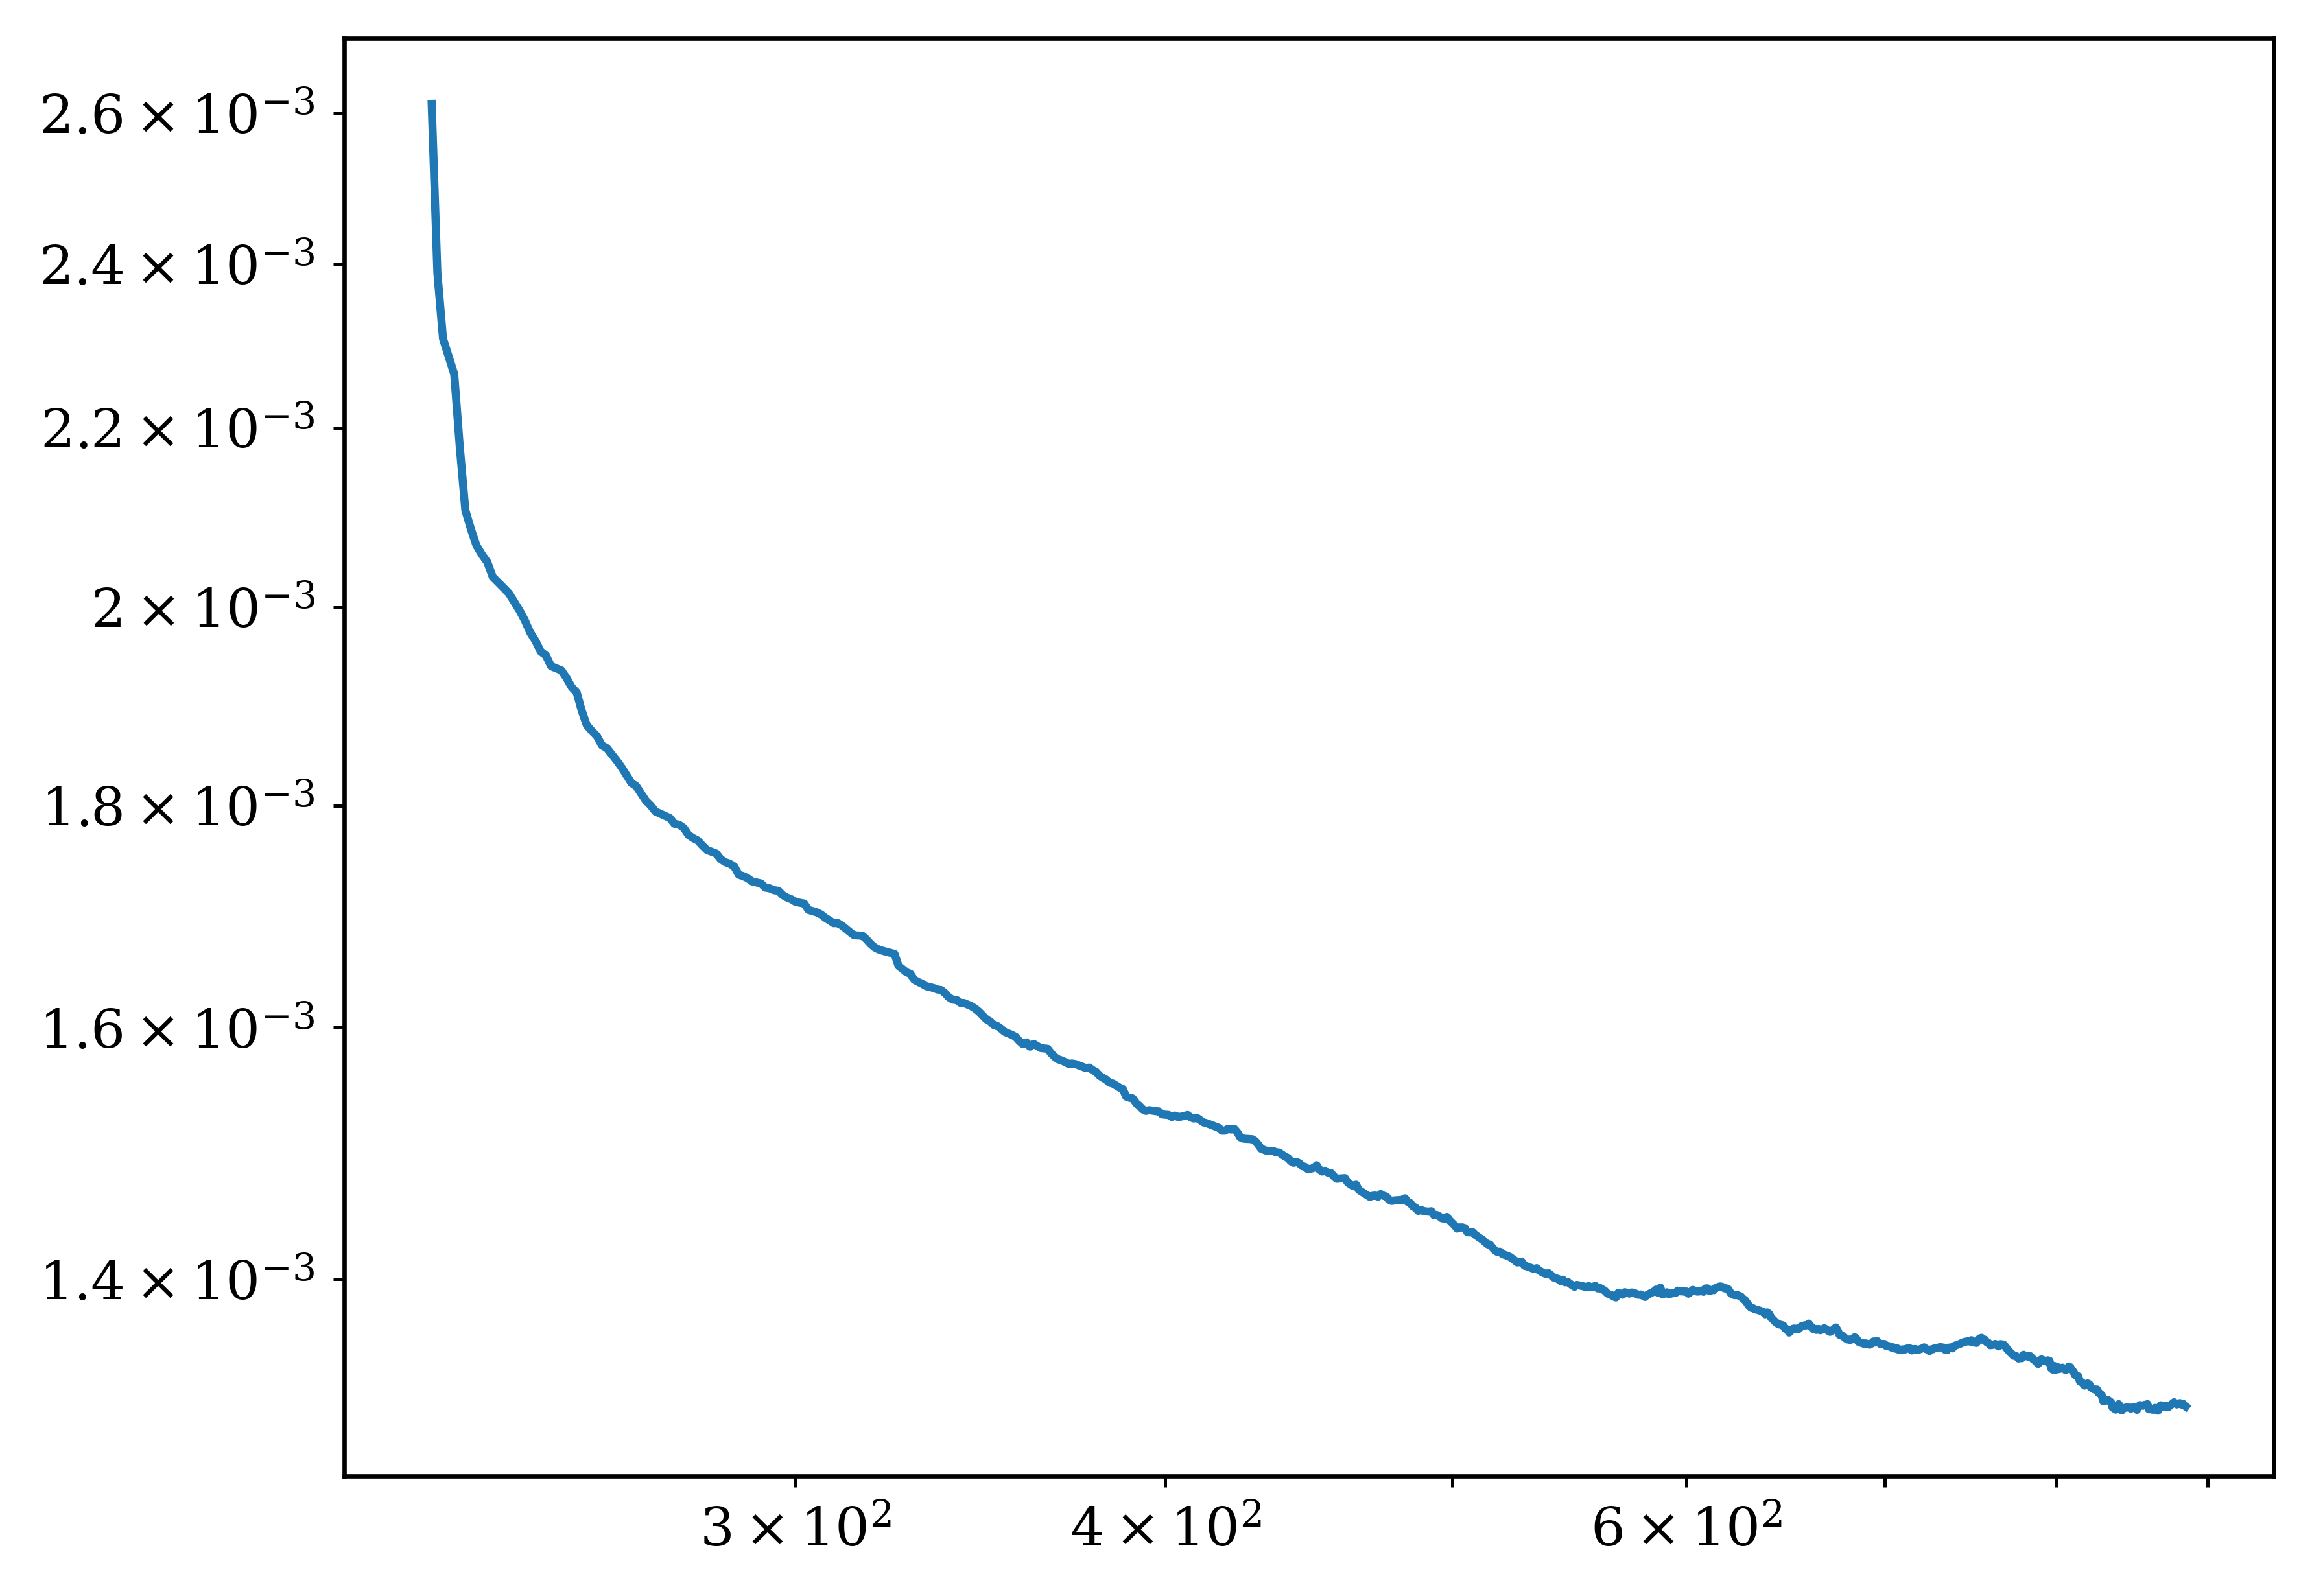

In [47]:
tmp_df.dropna(subset=['train_loss'])['train_loss'].rolling(201).mean().plot()
plt.yscale('log')
plt.xscale('log')

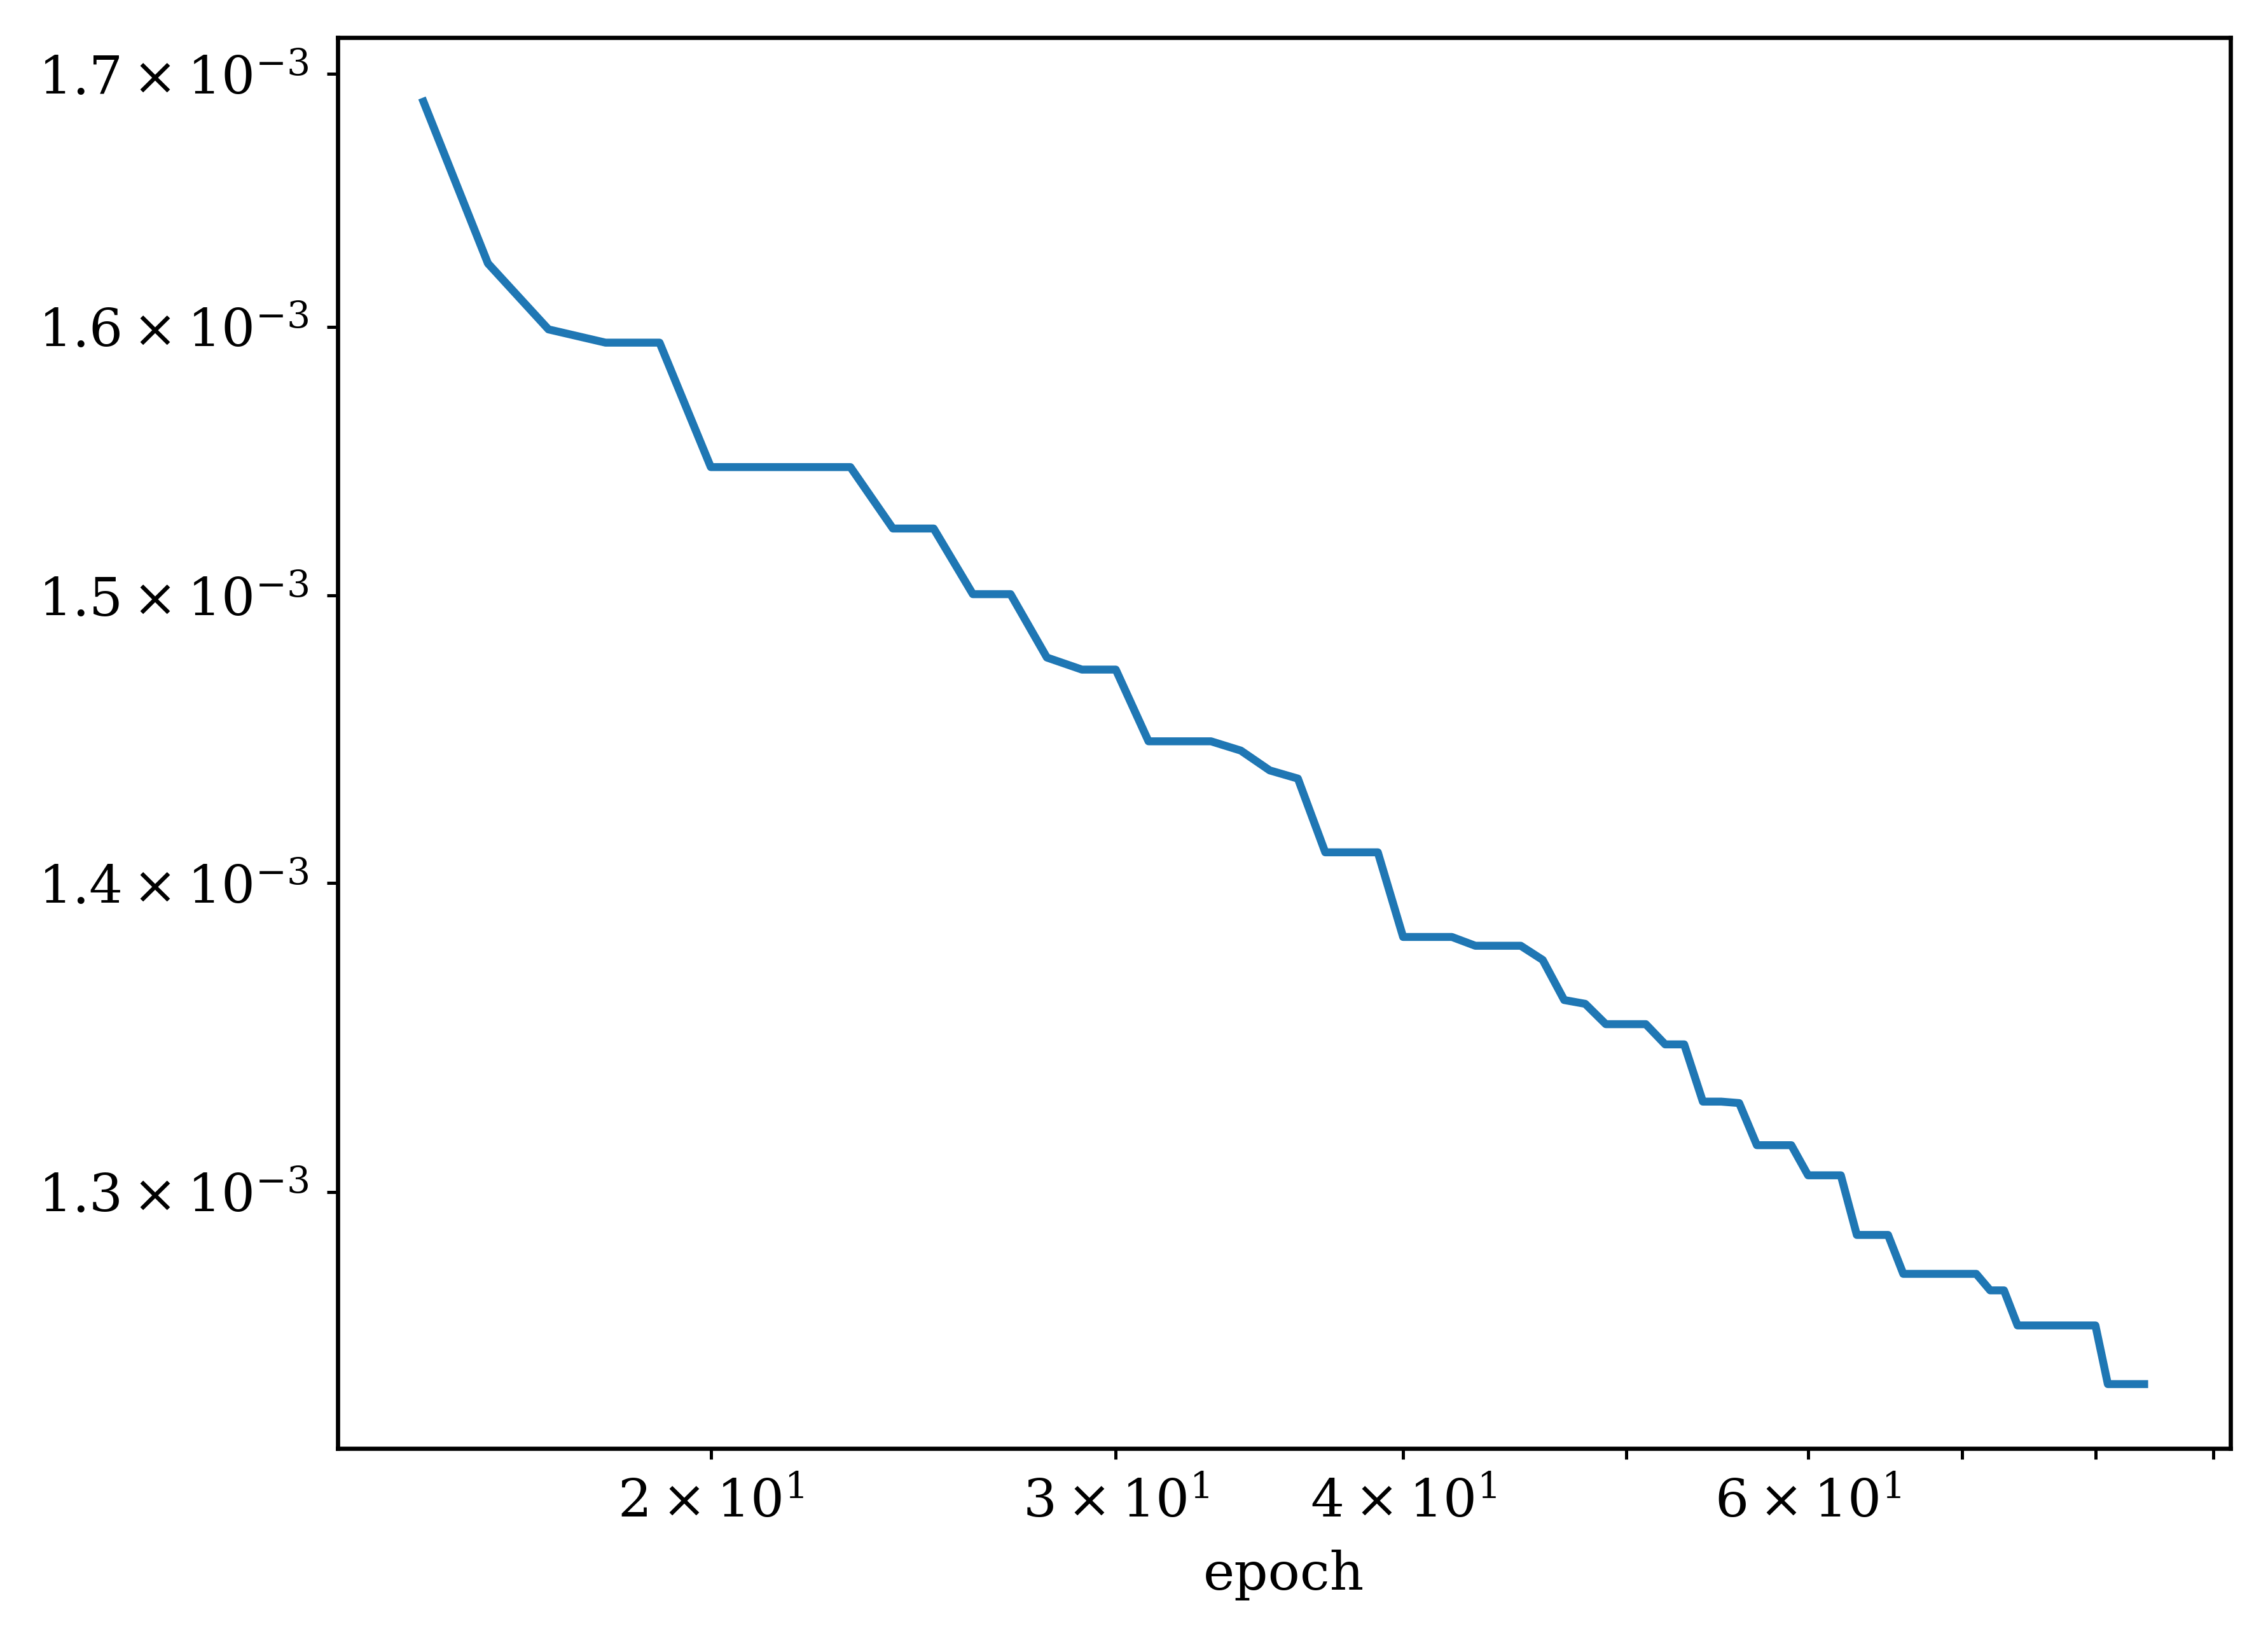

In [48]:
tmp_df.dropna(subset=['val_loss']).set_index('epoch')['val_loss'].rolling(16).min().plot()
plt.yscale('log')
plt.xscale('log')

In [49]:
tmp_df['epoch'].max()

84